In [126]:
import pandas as pd
import numpy as np
import requests
import math
import time
import json
from collections import Counter

import seaborn as sns

import plotly.express as px
import matplotlib.pyplot as plt

from summa import keywords

import ast

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

from nltk import TreebankWordTokenizer
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
#nltk.download('wordnet')
#nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
import string

import scispacy
import spacy

from langdetect import detect
from deep_translator import GoogleTranslator

from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
import multiprocessing
from time import time  # To time our operations

tokenizer = TreebankWordTokenizer()
stop_words_en = stopwords.words('english')
stop_words_fr = stopwords.words('french')
lemmatizer = WordNetLemmatizer()

punct = string.punctuation
punct = punct.replace("-", "") # don't remove hyphens


# Task 0: data extraction

In [35]:
PER_PAGE=200
WAIT_SECS=0.15
WORKS_FILE_PATH = './data/works.json'

In [ ]:
def fetch_page(cursor):
    base_url='https://api.openalex.org/works'
    url = '{base_url}?filter=from_publication_date:2017-01-01,to_publication_date:2021-12-31,raw_affiliation_string.search:grenoble&cursor={cursor}&per-page={per_page}&mailto={mailto}'.format(
        base_url=base_url,
        cursor=cursor,
        per_page=PER_PAGE,
        mailto='bertagrim@gmail.com'
    )
    print('Senging GET {url}'.format(url=url))
          
    response = requests.get(url)
    
    if (response.status_code == 200):
        print('OK')
        return response.json()
    else:
        print('Request failed: {status_code}'.format(status_code=response.status_code))
        print(response.text)
    


In [3]:
def save_entries(page_n, results):
    offset = page_n * PER_PAGE
    from_entry_num = offset
    to_entry_num = from_entry_num + len(results)
    print('Saving new entries in positions: {from_entry_num}..{to_entry_num}'.format(
        from_entry_num=from_entry_num,
        to_entry_num=to_entry_num
    ))
    with open(WORKS_FILE_PATH, 'r+', encoding='utf-8') as file:
        entries = json.load(file)
        entries[from_entry_num:] = results
        file.seek(0)
        json.dump(entries, file)

In [5]:
page_1 = fetch_page('*')
num_pages = math.ceil(page_1['meta']['count']/PER_PAGE)
num_pages

In [ ]:
cursor='*'
works=[]
for page_n in range(0, num_pages):
    print("Fetching page {} ...".format(page_n))
    page = fetch_page(cursor)
    works.extend(page['results'])
#     save_entries(
#         page_n=page_n,
#         results=page['results']
#     )
    time.sleep(WAIT_SECS)
    cursor=page['meta']['next_cursor']
    
with open(WORKS_FILE_PATH, 'w', encoding='utf-8') as file:
        json.dump(works, file)


In [36]:
with open(WORKS_FILE_PATH) as f:
    data = json.load(f)

In [37]:
data_string = json.dumps(data)

In [38]:
df = pd.read_json(data_string)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49579 entries, 0 to 49578
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       49579 non-null  object 
 1   doi                      39389 non-null  object 
 2   title                    49572 non-null  object 
 3   display_name             49572 non-null  object 
 4   relevance_score          49579 non-null  float64
 5   publication_year         49579 non-null  int64  
 6   publication_date         49579 non-null  object 
 7   ids                      49579 non-null  object 
 8   host_venue               49579 non-null  object 
 9   type                     46346 non-null  object 
 10  open_access              49579 non-null  object 
 11  authorships              49579 non-null  object 
 12  cited_by_count           49579 non-null  int64  
 13  biblio                   49579 non-null  object 
 14  is_retracted          

Regarding cleaning, at this point I do a very minimal cleaning. First, I drop a number of columns that I know I will not need for any of them (I know this only after having completed the tasks). I do this simply to make computation costs lower. Some of these columns would be useful in a deeper analysis. I will go back to this in Task 7 and explain how I think we could use some of them to extend our study.

In [39]:
df_clean=df.drop(columns=['is_authors_truncated', 
                 'is_retracted', 
                 'related_works', 
                 'display_name',
                 'alternate_host_venues', 
                 'mesh', 
                 'updated_date', 
                 'created_date', 
                 'open_access',
                 'cited_by_api_url',
                 'counts_by_year',
                 'biblio',
                 'host_venue',
                 'ids',
                 'open_access',
                 'referenced_works',
                 'related_works',
                 'relevance_score',
                 'ngrams_url'])

### Columns I kept

- 'id': identifier by OpenAlex
- 'title': title of the work 
- 'doi'
- 'publication_year': publication year.
- 'publication_date': publication date.
- 'type': type of work (journal, book, etc)
- 'authorships': object containing information about the author/s of the work.
- 'cited_by_count': how many works cite it 
- 'is_paratext' :  paratext is stuff that's in scholarly venue (like a journal) but is about the venue rather than a scholarly work properly speaking. 
- 'concepts': the concepts that the work is about.
- 'abstract_inverted_index': the abstract, as an inverted index.

In [58]:
df_clean.type.value_counts()

journal-article        33454
proceedings-article     7377
posted-content          2126
book-chapter            1887
dissertation             623
other                    351
book                     278
report                   133
peer-review               54
dataset                   16
proceedings               15
monograph                 11
reference-entry            8
component                  5
journal-issue              4
report-series              2
reference-book             1
journal                    1
Name: type, dtype: int64

In [59]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49579 entries, 0 to 49578
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       49579 non-null  object 
 1   doi                      39389 non-null  object 
 2   title                    49572 non-null  object 
 3   publication_year         49579 non-null  int64  
 4   publication_date         49579 non-null  object 
 5   type                     46346 non-null  object 
 6   authorships              49579 non-null  object 
 7   cited_by_count           49579 non-null  int64  
 8   is_paratext              43962 non-null  float64
 9   concepts                 49579 non-null  object 
 10  abstract_inverted_index  40226 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 4.2+ MB


Another thing we will have to deal with too is nulls. However, since my strategy throughout the tasks will be to created a custom dataset for each task, I will deal with nulls as needed in each particular case. If I were to, say, drop all of them now, I would lose a lot of information that I would otherwise have for specific tasks (in particular, 'abstract_inverted_index' has a higer number of nulls, but I will not need abstracts for some of the tasks). 

Next, I use the column 'is_paratext' to filter out works that are not scholarly works. I also drop this column afterwards.

In [60]:
df_clean.is_paratext.value_counts()

0.0    43921
1.0       41
Name: is_paratext, dtype: int64

In [40]:
df_clean=df_clean[df_clean.is_paratext==0.0].reset_index(drop=True)

In [41]:
#sanity check
df_clean.is_paratext.value_counts()

0.0    43921
Name: is_paratext, dtype: int64

In [42]:
df_clean.drop(columns='is_paratext', inplace=True)

Finally, there is the issue of duplicates. 

In [65]:
df_clean.head()

id  \
0  https://openalex.org/W2511949746   
1  https://openalex.org/W2805354595   
2  https://openalex.org/W4205946977   
3  https://openalex.org/W2796277309   
4  https://openalex.org/W2969802526   

                                            doi  \
0  https://doi.org/10.1016/j.eururo.2016.08.003   
1         https://doi.org/10.1056/nejmoa1716948   
2       https://doi.org/10.1111/1467-8330.00247   
3           https://doi.org/10.3762/bjnano.9.98   
4     https://doi.org/10.1038/s41575-019-0186-y   

                                               title  publication_year  \
0  EAU-ESTRO-SIOG Guidelines on Prostate Cancer. ...              2017   
1  Atezolizumab for First-Line Treatment of Metas...              2018   
2                              Neoliberalizing Space              2020   
3  Review on nanoparticles and nanostructured mat...              2018   
4  A global view of hepatocellular carcinoma: tre...              2019   

  publication_date             type  \
0       2017-04-01  journal-article   
1       2018-06-04  journal-article   
2       2020-06-22  journal-article   
3       2018-04-03  journal-article   
4       2019-08-22  journal-article   

                                         authorships  cited_by_count  \
0  [{'author_position': 'first', 'author': {'id':...            2240   
1  [{'author_position': 'first', 'author': {'id':...            2084   
2  [{'author_position': 'first', 'author': {'id':...            2513   
3  [{'author_position': 'first', 'author': {'id':...            1535   
4  [{'author_position': 'first', 'author': {'id':...            1592   

                                            concepts  \
0  [{'id': 'https://openalex.org/C71924100', 'wik...   
1  [{'id': 'https://openalex.org/C2775949291', 'w...   
2  [{'id': 'https://openalex.org/C2778572836', 'w...   
3  [{'id': 'https://openalex.org/C171250308', 'wi...   
4  [{'id': 'https://openalex.org/C71924100', 'wik...   

                             abstract_inverted_index  
0  {'To': [0], 'present': [1, 392], 'a': [2, 49, ...  
1  {'The': [0, 84, 147, 183, 330], 'cancer-cell-k...  
2                                               None  
3  {'Nanomaterials': [0], '(NMs)': [1], 'have': [...  
4  {'Hepatocellular': [0], 'carcinoma': [1], '(HC...

Finally, I deal with duplicates in a rather naive way, since I will go back to the problem of duplicates in Task 6. For now, I simply check if there are works that have the same features (I cannot use unhashable features, so I have to drop some columns; moreover, I know that the id is unqieu so I drop it too).

In [43]:
df_clean.drop(columns=['concepts', 'authorships', 'abstract_inverted_index', 'id']).duplicated().sum()

961

There are 961 works that have the same doi, title, publication year and date, type and cited_by_count. I think we can be fairly certain that these are indeed duplicates. So I drop them. In a real scenario, I would address this issue in more detail. To begin with I would investigate more how the data was colelcted and what might give rise to duplicates. As I said, I will go back to this in Task 6, where I will investigate a different way to detect duplicates.

In [44]:
df_clean=df_clean.drop_duplicates(subset=df_clean.drop(columns=['concepts', 'authorships', 'abstract_inverted_index', 'id']).columns).reset_index(drop=True)

In [45]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42960 entries, 0 to 42959
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       42960 non-null  object
 1   doi                      39176 non-null  object
 2   title                    42953 non-null  object
 3   publication_year         42960 non-null  int64 
 4   publication_date         42960 non-null  object
 5   type                     42945 non-null  object
 6   authorships              42960 non-null  object
 7   cited_by_count           42960 non-null  int64 
 8   concepts                 42960 non-null  object
 9   abstract_inverted_index  35817 non-null  object
dtypes: int64(2), object(8)
memory usage: 3.3+ MB


# Task 1: time trends and production indicators

First, I prepare the dataframe that I will need for this particular task.

In [46]:
df1=df_clean[['id', 'title', 'concepts', 'publication_year', 'publication_date']]

Let's see if we have to do any further cleaning. We check the nulls. There are very few. We just drop them.

In [47]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42960 entries, 0 to 42959
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                42960 non-null  object
 1   title             42953 non-null  object
 2   concepts          42960 non-null  object
 3   publication_year  42960 non-null  int64 
 4   publication_date  42960 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.6+ MB


In [48]:
df1_clean = df1.dropna().reset_index(drop=True)

In [49]:
df1_clean['publication_date']=pd.to_datetime(df1_clean['publication_date'])
df1_clean['month_year'] = pd.to_datetime(df1_clean['publication_date']).dt.to_period('M')
df1_clean['publication_month'] = pd.to_datetime(df1_clean['publication_date']).dt.month

We need to extract the concepts of level 0 to see to which general areas of research each work belongs.

In [50]:
def get_concepts_0(orig_list):
    pruned_list=[item['display_name'].lower().replace(' ', '-') for item in orig_list if item['level']==0]
    return pruned_list

df1_clean['concepts_level_0']=df1_clean['concepts'].apply(get_concepts_0)

In [51]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42953 entries, 0 to 42952
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 42953 non-null  object        
 1   title              42953 non-null  object        
 2   concepts           42953 non-null  object        
 3   publication_year   42953 non-null  int64         
 4   publication_date   42953 non-null  datetime64[ns]
 5   month_year         42953 non-null  period[M]     
 6   publication_month  42953 non-null  int64         
 7   concepts_level_0   42953 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4), period[M](1)
memory usage: 2.6+ MB


## Data analysis

In [52]:
df1_clean.publication_year.value_counts()

2021    8805
2017    8633
2018    8592
2020    8462
2019    8461
Name: publication_year, dtype: int64

<AxesSubplot: xlabel='publication_year', ylabel='count'>

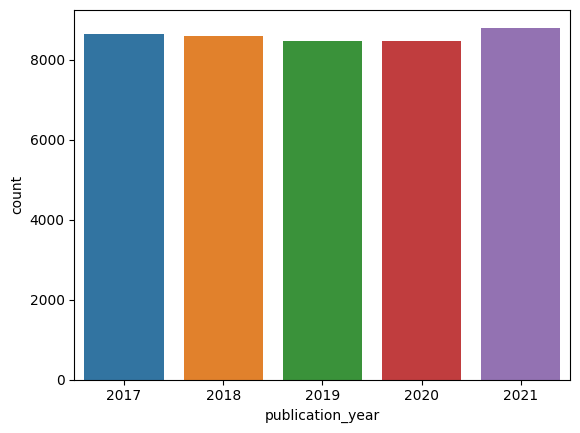

In [95]:
sns.countplot(data = df1_clean, x="publication_year")

The amount of publications with Grenoble authors per year is actually very stable. Interestingly, there is a constant decrease until 2021, where the number goes up. In a proper study, we would try to find out why that is the case. An initial hypothesis might be that it has to do with the COVID pandemic. As is well-known , the pandemic has given rise to a huge amount of publications in realtion with it. Could this be the exaplanation? We will be able to answer this question in a minute, when we analyze the count of works by year and area of research.

In [53]:
categories=[]
for item in df1_clean['concepts_level_0'].values:
    categories.extend(item)
unique=list(set(categories))
unique

['economics',
 'art',
 'medicine',
 'engineering',
 'philosophy',
 'chemistry',
 'mathematics',
 'history',
 'geography',
 'business',
 'computer-science',
 'political-science',
 'sociology',
 'environmental-science',
 'psychology',
 'physics',
 'biology',
 'materials-science',
 'geology']

In [54]:
s = df1_clean['concepts_level_0']
dummies = pd.get_dummies(s.apply(pd.Series), prefix='', prefix_sep='').sum(level=0, axis=1)
final = pd.concat([df1_clean, dummies], axis=1).drop(columns=['concepts', 'concepts_level_0'])

/var/folders/8t/pdc266556nvbq2phrrf21cd00000gn/T/ipykernel_6574/4120625108.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dummies = pd.get_dummies(s.apply(pd.Series), prefix='', prefix_sep='').sum(level=0, axis=1)
/var/folders/8t/pdc266556nvbq2phrrf21cd00000gn/T/ipykernel_6574/4120625108.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies = pd.get_dummies(s.apply(pd.Series), prefix='', prefix_sep='').sum(level=0, axis=1)


In [99]:
grouped = final.groupby(['publication_year'])
grouped_months = final.groupby(['month_year'])

In [175]:
df_years=pd.DataFrame()
for value in unique:
    df_years[value]=grouped[value].sum()
df_years=df_years.reset_index()

In [177]:
df_months=pd.DataFrame()
for value in unique:
    df_months[value]=grouped_months[value].sum()
df_months=df_months.reset_index()

First, we look at a line plot with all the disciplines. It's not the clearest plot, that's why we used interactive annotations. If you hover over the different points, you can check its different attributes.

In [176]:
fig = px.line(df_years, markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0 , 1 , 2 , 3 , 4], 
        ticktext =['2017','2018','2019','2020','2021']
    )
)
fig.update_layout(
     xaxis_title="Year",
    yaxis_title="Number of publications",
    legend_title="Discipline",
    autosize=False,
    width=1000,
    height=700)

fig.update_yaxes(range=[-100, 3700])
fig.show()

In [201]:
#falta
diffs=df_years.T
diffs['diff_19_21'] = diffs.iloc[:, 4].sub(diffs.iloc[:,2], axis=0)
diffs['diff_20_21'] = diffs.iloc[:, 4].sub(diffs.iloc[:,3], axis=0)

diffs

0       1       2       3       4  diff_19_21  \
publication_year       2017.0  2018.0  2019.0  2020.0  2021.0         2.0   
physics                3538.0  3493.0  3447.0  3436.0  3419.0       -28.0   
geography               402.0   461.0   472.0   472.0   582.0       110.0   
engineering            1944.0  1882.0  1829.0  1725.0  1834.0         5.0   
chemistry              2074.0  1937.0  2011.0  2166.0  2136.0       125.0   
materials-science      2718.0  2539.0  2462.0  2445.0  2302.0      -160.0   
art                     286.0   325.0   307.0   306.0   281.0       -26.0   
environmental-science   428.0   460.0   500.0   471.0   549.0        49.0   
philosophy              528.0   580.0   575.0   611.0   650.0        75.0   
history                  53.0    76.0    83.0    90.0    84.0         1.0   
geology                 873.0   923.0   937.0   987.0  1087.0       150.0   
sociology               238.0   286.0   293.0   279.0   410.0       117.0   
economics               408.0   432.0   410.0   398.0   546.0       136.0   
mathematics            1474.0  1437.0  1449.0  1419.0  1620.0       171.0   
political-science       452.0   513.0   516.0   446.0   594.0        78.0   
business                279.0   285.0   275.0   277.0   340.0        65.0   
biology                1572.0  1559.0  1624.0  1832.0  2005.0       381.0   
computer-science       3016.0  3093.0  2940.0  2730.0  2898.0       -42.0   
psychology              509.0   550.0   509.0   563.0   695.0       186.0   
medicine               1791.0  1767.0  1819.0  2011.0  2168.0       349.0   

                       diff_20_21  
publication_year              1.0  
physics                     -17.0  
geography                   110.0  
engineering                 109.0  
chemistry                   -30.0  
materials-science          -143.0  
art                         -25.0  
environmental-science        78.0  
philosophy                   39.0  
history                      -6.0  
geology                     100.0  
sociology                   131.0  
economics                   148.0  
mathematics                 201.0  
political-science           148.0  
business                     63.0  
biology                     173.0  
computer-science            168.0  
psychology                  132.0  
medicine                    157.0

In [212]:
diffs.drop('publication_year').sort_values(by=['diff_19_21'])

0       1       2       3       4  diff_19_21  \
materials-science      2718.0  2539.0  2462.0  2445.0  2302.0      -160.0   
computer-science       3016.0  3093.0  2940.0  2730.0  2898.0       -42.0   
physics                3538.0  3493.0  3447.0  3436.0  3419.0       -28.0   
art                     286.0   325.0   307.0   306.0   281.0       -26.0   
history                  53.0    76.0    83.0    90.0    84.0         1.0   
engineering            1944.0  1882.0  1829.0  1725.0  1834.0         5.0   
environmental-science   428.0   460.0   500.0   471.0   549.0        49.0   
business                279.0   285.0   275.0   277.0   340.0        65.0   
philosophy              528.0   580.0   575.0   611.0   650.0        75.0   
political-science       452.0   513.0   516.0   446.0   594.0        78.0   
geography               402.0   461.0   472.0   472.0   582.0       110.0   
sociology               238.0   286.0   293.0   279.0   410.0       117.0   
chemistry              2074.0  1937.0  2011.0  2166.0  2136.0       125.0   
economics               408.0   432.0   410.0   398.0   546.0       136.0   
geology                 873.0   923.0   937.0   987.0  1087.0       150.0   
mathematics            1474.0  1437.0  1449.0  1419.0  1620.0       171.0   
psychology              509.0   550.0   509.0   563.0   695.0       186.0   
medicine               1791.0  1767.0  1819.0  2011.0  2168.0       349.0   
biology                1572.0  1559.0  1624.0  1832.0  2005.0       381.0   

                       diff_20_21  
materials-science          -143.0  
computer-science            168.0  
physics                     -17.0  
art                         -25.0  
history                      -6.0  
engineering                 109.0  
environmental-science        78.0  
business                     63.0  
philosophy                   39.0  
political-science           148.0  
geography                   110.0  
sociology                   131.0  
chemistry                   -30.0  
economics                   148.0  
geology                     100.0  
mathematics                 201.0  
psychology                  132.0  
medicine                    157.0  
biology                     173.0

An initial observation is that medicine and biology are the two disciplines that go up most significantly between 2019 and 2021, which could be explained by the covid-related publications. However they are by no means the only one. In fact, most diciplines go up in that period. This rise of publications pretty much accross the board could still be explained by covid: could it be that researchers were more productive throughout the pandemic period, due having less teaching duties/meetings/other in person events? This is something I would look into in a longer study. 

As follows, I plot the same information for separate groups of disciplines, to have a closer look inside each group.

In [155]:
social=['economics', 'sociology', 'political-science', 'business', 'geography']
science=['medicine', 'biology',  'psychology']
earth=['environmental-science', 'geology', 'materials-science']
engineering_maths=['engineering', 'computer-science', 'chemistry', 'physics', 'mathematics']
humanities=['philosophy', 'history', 'art']

df_social=df_years[social]
df_earth=df_years[earth]
df_science=df_years[science]
df_engineering=df_years[engineering_maths]
df_humanities=df_years[humanities]

In [158]:
fig = px.line(df_social, title="Social sciences", markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0 , 1 , 2 , 3 , 4], 
        ticktext =['2017','2018','2019','2020','2021']
    )
)
fig.update_layout(
     xaxis_title="Year",
    yaxis_title="Number of publications",
    legend_title="Discipline",
    autosize=False,
    width=700,
    height=400)
fig.show()

In [180]:
fig = px.line(df_earth, title="Earth sciences", markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0 , 1 , 2 , 3 , 4], 
        ticktext =['2017','2018','2019','2020','2021']
    )
)
fig.update_layout(
     xaxis_title="Year",
    yaxis_title="Number of publications",
    legend_title="Discipline",
    autosize=False,
    width=700,
    height=400)
fig.show()

In [161]:
fig = px.line(df_engineering, title="Engineering and maths", markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0 , 1 , 2 , 3 , 4], 
        ticktext =['2017','2018','2019','2020','2021']
    )
)
fig.update_layout(
     xaxis_title="Year",
    yaxis_title="Number of publications",
    legend_title="Discipline",
    autosize=False,
    width=700,
    height=400)
fig.show()

In [165]:
fig = px.line(df_science, title="Biological sciences", markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0 , 1 , 2 , 3 , 4], 
        ticktext =['2017','2018','2019','2020','2021']
    )
)
fig.update_layout(
     xaxis_title="Year",
    yaxis_title="Number of publications",
    legend_title="Discipline",
    autosize=False,
    width=700,
    height=400)
fig.show()

In [166]:
fig = px.line(df_humanities, title="Humanities", markers=True)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [0 , 1 , 2 , 3 , 4], 
        ticktext =['2017','2018','2019','2020','2021']
    )
)
fig.update_layout(
     xaxis_title="Year",
    yaxis_title="Number of publications",
    legend_title="Discipline",
    autosize=False,
    width=700,
    height=400)
fig.show()

Observations: 

- Social sciences observe a significant rise from 2020 to 2021 across the board. At this point, I don't know why that is the case. I would need to gather more domain knowledge.
- Another relevant tendencyt that we already observed is that what I called "biological sciences" (for lack of a better term) also go up in all its subdisciplines from 2019 to 2021. I already suggested some possible causes of this, but a proper study would need to be undertaken to find out why.
- Finally, note that the only... 
#falta

Let's finish by taking a look at the monthly progress of publication counts.


In [181]:
y_cols=df_months.drop(columns='month_year').columns
y_cols

Index(['physics', 'geography', 'engineering', 'chemistry', 'materials-science',
       'art', 'environmental-science', 'philosophy', 'history', 'geology',
       'sociology', 'economics', 'mathematics', 'political-science',
       'business', 'biology', 'computer-science', 'psychology', 'medicine'],
      dtype='object')

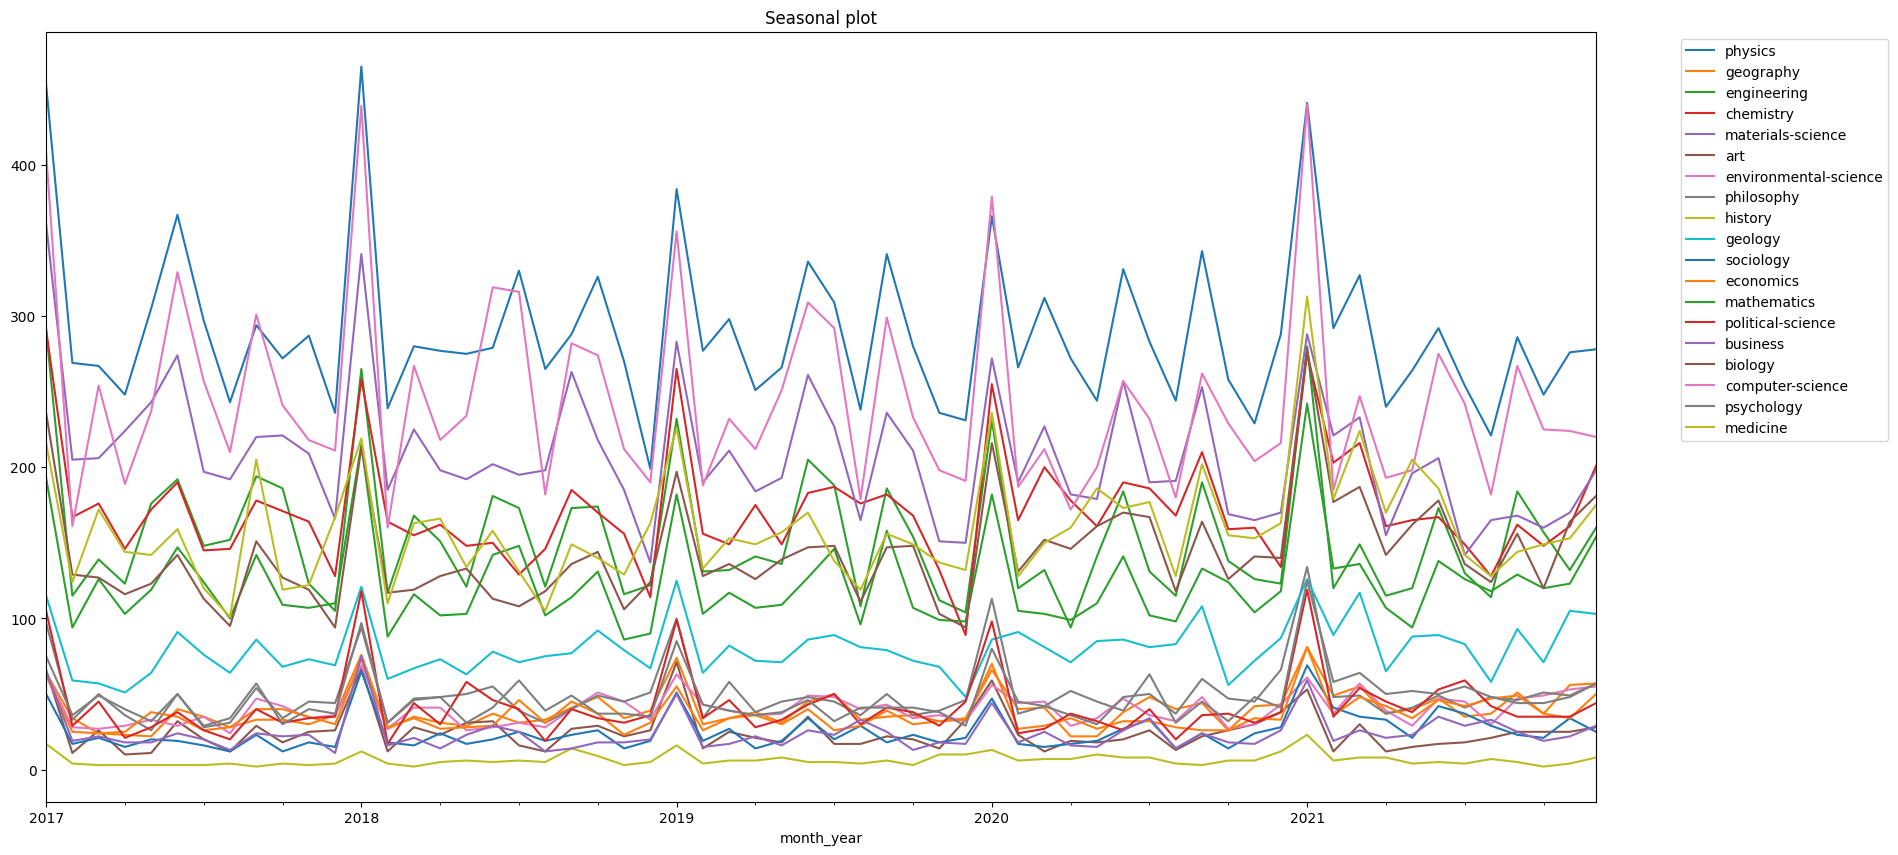

In [193]:
pd.options.plotting.backend = 'matplotlib'

df_months.plot(x='month_year', 
             y=y_cols, 
             title='hello');
plt.rcParams["figure.figsize"] = (20,10)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# add title
plt.title('Seasonal plot')

# move the legend outside of the main figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);


We observe seasonality straightaway. Let us plot the monthly progressions in more detail by confirming tthe trend we already observe in this plot.

In [194]:
d1 = {}
for x in unique:
    d1["{}".format(x)] = final[[x, "publication_year", "publication_month"]][final[x]==1]

In [195]:
d2={}
for key, value in d1.items():
    d2["grouped_{}".format(key)] = value.groupby(['publication_year','publication_month']).count()

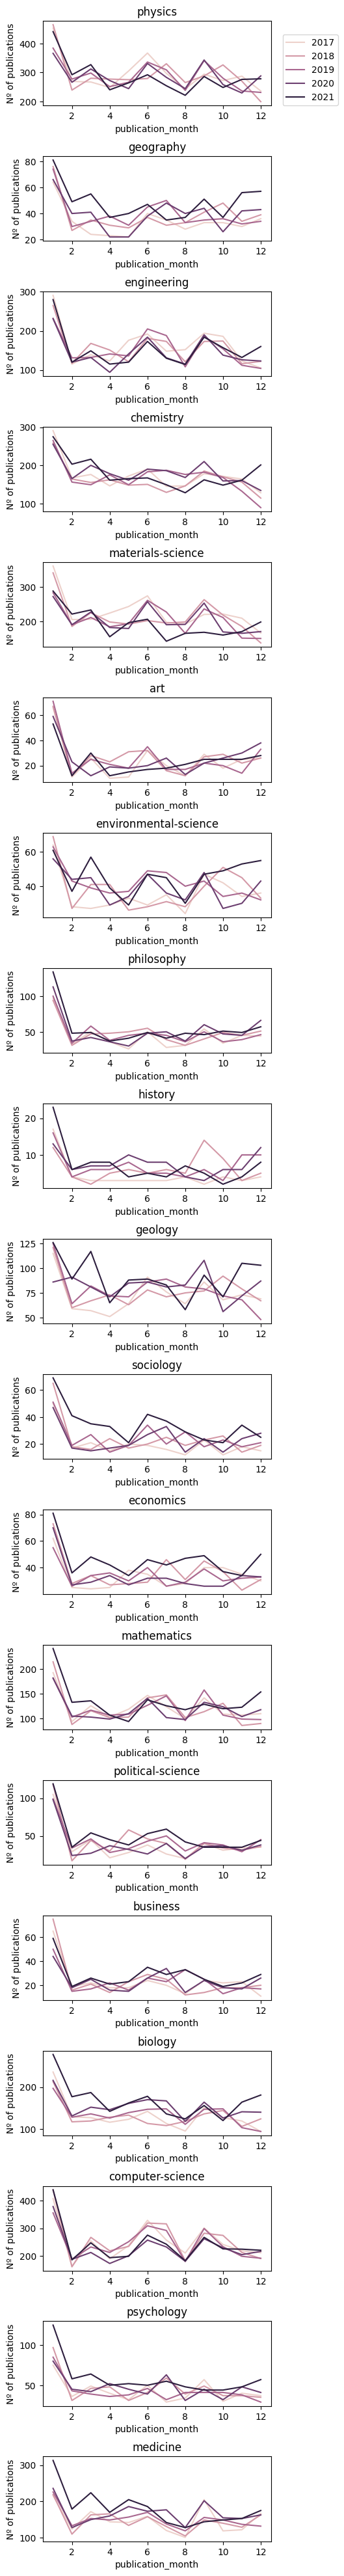

In [196]:
fig, axes = plt.subplots(19, 1, figsize=(5, 40))
fig.tight_layout(pad=3.5)
 
for k, key in enumerate(d2):
    if k==0:
        ax=sns.lineplot(ax=axes[k],
             data=d2[key], 
             x='publication_month', 
             y=key.split('_')[1], 
             hue='publication_year',
            legend=True)
        ax.set(ylabel='Nº of publications')
        ax.set(title=key.split('_')[1])
        ax.legend(loc=(1.05, 0))
    else:
        ax=sns.lineplot(ax=axes[k],
             data=d2[key], 
             x='publication_month', 
             y=key.split('_')[1], 
             hue='publication_year',
            legend=False)
        ax.set(title=key.split('_')[1])
        ax.set(ylabel='Nº of publications')

The seasonal trend gets confirmed in these plots: the beginning of the year sees a much higher number of publications. Moreover, there seems to be a rise around June and around September for most disciplines too.

# Task 2: collaboration network

For this task I will define 3 notions of connectedness, understood as measuring how connected a given author is to other Grenoble authors. Since this is a vague notion, it can be made precise in various ways. The notions I use are:

- *Connectedness 1*: How many publications with other Grenoble-based authors the author has. This count gives a higher weight to those authors that are prolific, even if they haven't collaborated with too many different people.
 - Connectedness 2: With how many different Grenoble-based authors the author has published. This other notion focuses on the number of people the author has collaborated with and sets aside whether the author has published a lot or not.
- *Connectedness 3*: A multiplication of both previous notions, givin us a combined factor.

In a longer study, I would have liked to explore other notions of connectedness. A couple of ideas:
 - A factor of the first two together with the average impact factor (in some of its forms) of the relevant publications, to see if as well as connected, the collaborations are having impactful outcomes.
 - A recursive notion of connectedness where an author is more connected the more connections they have with more connected authors.
 
But for the purposes of this exercise, let's have a look at the first three.

In [219]:
df2 = df_clean[['id', 'authorships',]]
df2.info()
#there are no nulls. No further cleaning required.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42960 entries, 0 to 42959
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           42960 non-null  object
 1   authorships  42960 non-null  object
dtypes: object(2)
memory usage: 671.4+ KB


In [217]:
def num_grenoble_authors(row):
    num=len([author for author in row['authorships'] if (author['raw_affiliation_string'] is not None) and ("grenoble" in author['raw_affiliation_string'].lower())])
    if num>1:
        return 1
    else:
        return 0

In [220]:
df2['is_work_connected'] = df2.apply(num_grenoble_authors, axis=1)

/var/folders/8t/pdc266556nvbq2phrrf21cd00000gn/T/ipykernel_3948/81781065.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [222]:
df2.is_work_connected.value_counts()

1    21879
0    21081
Name: is_work_connected, dtype: int64

In [223]:
def extract_author_ids(row):
    authors = [author['author']['id'] for author in row['authorships']]
    return authors

df2['authors'] = df2.apply(lambda row: extract_author_ids(row), axis=1) 

/var/folders/8t/pdc266556nvbq2phrrf21cd00000gn/T/ipykernel_3948/316629148.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [224]:
flat_list = [item for items in df2.authorships.values for item in items if (item['raw_affiliation_string'] is not None) and ('grenoble' in item['raw_affiliation_string'].lower())]

authors_sim = [{'author_id': item['author']['id'],
              'name':item['author']['display_name']}
               for item in flat_list]

In [226]:
grenoble_authors = pd.DataFrame.from_dict(authors_sim)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106099 entries, 0 to 106098
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   author_id  106099 non-null  object
 1   name       106099 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


In [227]:
grenoble_authors.duplicated().sum()

75168

In [228]:
grenoble_authors = grenoble_authors.drop_duplicates(ignore_index=True)

In [229]:
grenoble_authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30931 entries, 0 to 30930
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author_id  30931 non-null  object
 1   name       30931 non-null  object
dtypes: object(2)
memory usage: 483.4+ KB


In [234]:
work_author_pairs = df2[df2['is_work_connected']==1][['id', 'authors']]

In [235]:
work_author_pairs = work_author_pairs.explode('authors')

In [236]:
grenoble_work_author_pairs = work_author_pairs[work_author_pairs['authors'].isin(grenoble_authors['author_id'])]

In [237]:
count_works = grenoble_work_author_pairs.groupby('authors').count().reset_index()
count_works

authors  id
0      https://openalex.org/A1002805135   2
1      https://openalex.org/A1007915466   6
2       https://openalex.org/A100908830   1
3      https://openalex.org/A1009761877   4
4      https://openalex.org/A1015310080   1
...                                 ...  ..
26082   https://openalex.org/A974871389  15
26083   https://openalex.org/A975039927   1
26084    https://openalex.org/A97906723   6
26085   https://openalex.org/A985776687   4
26086   https://openalex.org/A992533987   2

[26087 rows x 2 columns]

### Connectedness 1

In [238]:
def get_connectedness1(row):
    author_id = row['author_id']
    if not count_works['id'][count_works['authors']==author_id].empty:
        count = count_works['id'][count_works['authors']==author_id].values[0]
        return count
    else:
        return 0

In [239]:
grenoble_authors['connectedness_1']=grenoble_authors.apply(get_connectedness1, axis=1)

In [240]:
grenoble_authors.to_csv('data/grenoble_authors1.csv', index=False)

Something I observed is that there is duplication of names, with different ids. Since personal names are quite easy to be actually duplicated in real life, I did not delete them. I only removed duplicates in both the id and the name. In a proper study, I would get more information about the authors (perhaps downloading author information from the same API would be enough) and try to find out if these are really duplicates or not.

In [241]:
grenoble_authors[grenoble_authors.name=="Jean-Louis Pépin"]

author_id              name  connectedness_1
8      https://openalex.org/A2596381244  Jean-Louis Pépin              205
13158  https://openalex.org/A4227283002  Jean-Louis Pépin                1
19310  https://openalex.org/A4202217154  Jean-Louis Pépin                1
27866  https://openalex.org/A4260292885  Jean-Louis Pépin                1
29688  https://openalex.org/A4261509675  Jean-Louis Pépin                1

### Connectedness 2

In [243]:
def get_connectedness2(row):
    author_id = row['author_id']
    works = grenoble_work_author_pairs['id'][grenoble_work_author_pairs['authors']==author_id]
    num_colabs = len(np.unique((grenoble_work_author_pairs['authors'][(grenoble_work_author_pairs['authors']!=author_id) & grenoble_work_author_pairs['id'].isin(list(works))]).values))
    return num_colabs

In [244]:
grenoble_authors['connectedness_2']=grenoble_authors.apply(get_connectedness2, axis=1)

In [245]:
grenoble_authors.to_csv('data/grenoble_authors2.csv', index=False)

In [246]:
grenoble_authors = pd.read_csv('data/grenoble_authors.csv')  

In [248]:
grenoble_authors.head()

author_id                 name  connectedness_1  \
0  https://openalex.org/A2081927895         Michel Bolla                1   
1  https://openalex.org/A2967507403  Christian A. Thomas                0   
2  https://openalex.org/A4208415029       Frédéric Bally                0   
3  https://openalex.org/A2050409607       Alain Dufresne               38   
4  https://openalex.org/A2061986354       Pierre Hainaut               23   

   connectedness_2  
0                8  
1                0  
2                0  
3               36  
4              103

### Connectedness 3

In [249]:
grenoble_authors['connectedness_3'] = grenoble_authors['connectedness_1'] * grenoble_authors['connectedness_2']

In [250]:
grenoble_authors.nlargest(10, 'connectedness_3')

author_id                  name  connectedness_1  \
8     https://openalex.org/A2596381244      Jean-Louis Pépin              206   
2037  https://openalex.org/A2196954048       Gerard Ghibaudo              148   
173   https://openalex.org/A2420782966       Renaud Tamisier              180   
1397  https://openalex.org/A1975902673  Jean-François Timsit              130   
613   https://openalex.org/A2308027254         J.M. Hartmann              101   
205   https://openalex.org/A1955230402          Yohann Couté               97   
1430  https://openalex.org/A2974844775            Maud Vinet               88   
1851  https://openalex.org/A2171459722     Laurence Bouillet               94   
1429  https://openalex.org/A1916288200       Sylvain Barraud               92   
1175  https://openalex.org/A2577985073       Jean-Luc Bosson               60   

      connectedness_2  connectedness_3  
8                 220            45320  
2037              249            36852  
173               179            32220  
1397              207            26910  
613               248            25048  
205               244            23668  
1430              231            20328  
1851              203            19082  
1429              177            16284  
1175              255            15300

By sorting the data by the third notion of connectedness we get a tope 10 of the most connected authors. Let's take a quick look at the structure of the data.

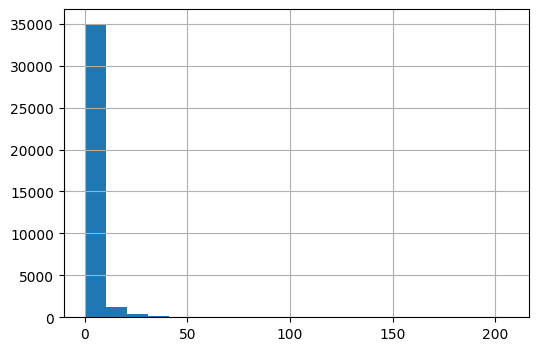

In [260]:
plt.figure(figsize=(6,4))
hist = grenoble_authors['connectedness_1'].hist(bins=20)

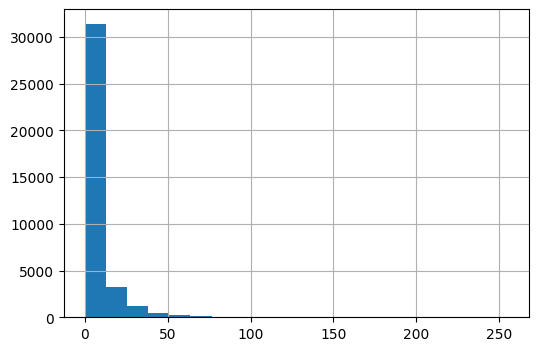

In [259]:
plt.figure(figsize=(6,4))
hist = grenoble_authors['connectedness_2'].hist(bins=20)

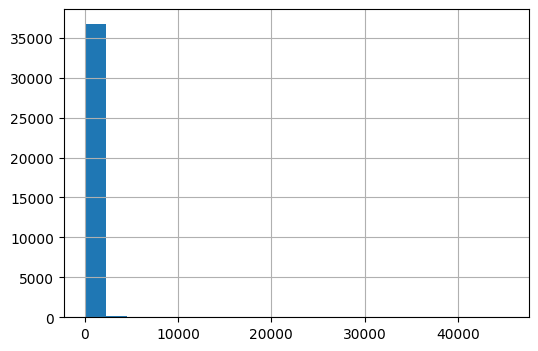

In [257]:
plt.figure(figsize=(6,4))
hist = grenoble_authors['connectedness_3'].hist(bins=20)

{'whiskers': [<matplotlib.lines.Line2D at 0x7ffa8cff5a20>,
 'caps': [<matplotlib.lines.Line2D at 0x7ffa8cff5f60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ffa8cff5810>],
 'medians': [<matplotlib.lines.Line2D at 0x7ffa8cff64a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ffa8cff6740>],
 'means': []}

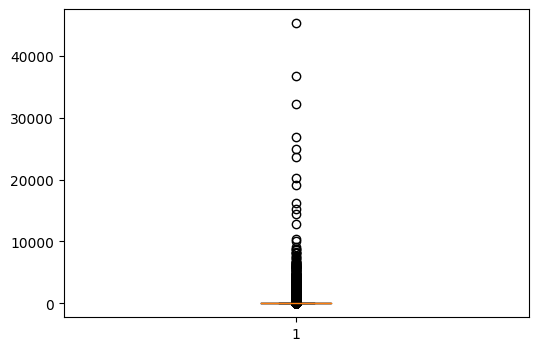

In [258]:
plt.figure(figsize=(6,4))
plt.boxplot(grenoble_authors['connectedness_3'])

The data is extremely skewed. What this tells us is that there are very few authors that are much more connected than the rest. Most of the Grenoble-based authors are not very connected at all. This means that the network of collaboration we are looking at is one where there are a few very central nodes and an extremely large amount of nodes that are in the outskirts of the graph. In other words, the collaboration is not at all well distributed across the population. A few people manage to collaborate with a lot of other people and publish a lot, but most people don't. This is something we would have to focus on when trying to improve the interconnectivity of the Grenoble academic world, since, presumably, what we are interested in is having a situation where most people are connected with other Grenoble-based researchers. So this would be one of the insights I would offer to the stakeholders in this case.

# Task 3: keywords

In [263]:
df3 = df_clean[['id', 'title', 'abstract_inverted_index']]

In [264]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42960 entries, 0 to 42959
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       42960 non-null  object
 1   title                    42953 non-null  object
 2   abstract_inverted_index  35817 non-null  object
dtypes: object(3)
memory usage: 1007.0+ KB


We are missing quite a few abstracts, so we drop those datapoints.

In [265]:
df3 = df3.dropna().reset_index(drop=True)

Moreover, some indexs are actually empty dictionaries. We drop those too.

In [266]:
df3 = df3[df3['abstract_inverted_index']!={}].reset_index(drop=True)

In [267]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35802 entries, 0 to 35801
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       35802 non-null  object
 1   title                    35802 non-null  object
 2   abstract_inverted_index  35802 non-null  object
dtypes: object(3)
memory usage: 839.2+ KB


In [ ]:
df3 = df3.drop_duplicates(subset=['title'], ignore_index=True)

### We compose the index:

In [269]:
def compose_abstract(row):
    inverted_index=row['abstract_inverted_index']
    
    num_to_word={}
    for key, values in inverted_index.items():
        for value in values:
            num_to_word[value]=key

    abstract=[]
    k=0
    while k <= max(num_to_word.keys()):
        if k in num_to_word: 
            abstract.append(num_to_word[k])
        k+=1

    return ' '.join(abstract)

In [270]:
df3['abstract']=df3.apply(compose_abstract, axis=1)

In [273]:
df3.head()

id  \
0  https://openalex.org/W2511949746   
1  https://openalex.org/W2805354595   
2  https://openalex.org/W2796277309   
3  https://openalex.org/W2969802526   
4  https://openalex.org/W2885896746   

                                               title  \
0  EAU-ESTRO-SIOG Guidelines on Prostate Cancer. ...   
1  Atezolizumab for First-Line Treatment of Metas...   
2  Review on nanoparticles and nanostructured mat...   
3  A global view of hepatocellular carcinoma: tre...   
4  Clinical Practice Guidelines for the Preventio...   

                             abstract_inverted_index  \
0  {'To': [0], 'present': [1, 392], 'a': [2, 49, ...   
1  {'The': [0, 84, 147, 183, 330], 'cancer-cell-k...   
2  {'Nanomaterials': [0], '(NMs)': [1], 'have': [...   
3  {'Hepatocellular': [0], 'carcinoma': [1], '(HC...   
4  {'To': [0], 'update': [1], 'and': [2, 15, 27, ...   

                                            abstract  
0  To present a summary of the 2016 version of th...  
1  The cancer-cell-killing property of atezolizum...  
2  Nanomaterials (NMs) have gained prominence in ...  
3  Hepatocellular carcinoma (HCC) is the fourth m...  
4  To update and expand the 2013 Clinical Practic...

For the purpose of this task, I focus on abstracts written in English.

In [278]:
def detect_lang(x):
    try:
        return str(detect(x))
    except:
        return 'No language detected.'
        print(x)

In [279]:
df3['lang']=df3.abstract.apply(detect_lang)

In [276]:
df3

id  \
0      https://openalex.org/W2511949746   
1      https://openalex.org/W2805354595   
2      https://openalex.org/W2796277309   
3      https://openalex.org/W2969802526   
4      https://openalex.org/W2885896746   
...                                 ...   
35797  https://openalex.org/W4200599600   
35798  https://openalex.org/W4205416072   
35799  https://openalex.org/W4205834098   
35800  https://openalex.org/W4207070375   
35801  https://openalex.org/W4225842698   

                                                   title  \
0      EAU-ESTRO-SIOG Guidelines on Prostate Cancer. ...   
1      Atezolizumab for First-Line Treatment of Metas...   
2      Review on nanoparticles and nanostructured mat...   
3      A global view of hepatocellular carcinoma: tre...   
4      Clinical Practice Guidelines for the Preventio...   
...                                                  ...   
35797  Superquantiles at Work: Machine Learning Appli...   
35798  Combined Use of Whole Exome Sequencing and CRI...   
35799  Nanoscale mineralogy and organic structure in ...   
35800  HIV-1 Nef Protein Affects Cytokine and Extrace...   
35801  Superquantiles at Work: Machine Learning Appli...   

                                 abstract_inverted_index  \
0      {'To': [0], 'present': [1, 392], 'a': [2, 49, ...   
1      {'The': [0, 84, 147, 183, 330], 'cancer-cell-k...   
2      {'Nanomaterials': [0], '(NMs)': [1], 'have': [...   
3      {'Hepatocellular': [0], 'carcinoma': [1], '(HC...   
4      {'To': [0], 'update': [1], 'and': [2, 15, 27, ...   
...                                                  ...   
35797  {'R.': [0], 'Tyrell': [1], 'Rockafellar': [2],...   
35798  {'The': [0], 'genetic': [1], 'landscape': [2],...   
35799  {'Meteorite': [0], 'matrices': [1, 187], 'from...   
35800  {'Plasmacytoid': [0], 'dendritic': [1, 7, 73],...   
35801  {'R.': [0], 'Tyrell': [1], 'Rockafellar': [2],...   

                                                abstract  \
0      To present a summary of the 2016 version of th...   
1      The cancer-cell-killing property of atezolizum...   
2      Nanomaterials (NMs) have gained prominence in ...   
3      Hepatocellular carcinoma (HCC) is the fourth m...   
4      To update and expand the 2013 Clinical Practic...   
...                                                  ...   
35797  R. Tyrell Rockafellar and his collaborators in...   
35798  The genetic landscape of male infertility is h...   
35799  Meteorite matrices from primitive chondrites a...   
35800  Plasmacytoid dendritic cells (pDCs) are a uniq...   
35801  R. Tyrell Rockafellar and collaborators introd...   

                        lang  
0      No language detected.  
1      No language detected.  
2      No language detected.  
3      No language detected.  
4      No language detected.  
...                      ...  
35797  No language detected.  
35798  No language detected.  
35799  No language detected.  
35800  No language detected.  
35801  No language detected.  

[35802 rows x 5 columns]

In [280]:
df3.to_csv('data/abstracts_langs.csv', index=False)

In [56]:
df3 = pd.read_csv('data/abstracts_langs.csv')  

In [57]:
df3.lang.value_counts()

en                       33821
fr                        1834
es                          67
pt                          17
it                          16
ca                          13
de                          13
nl                           8
ru                           3
pl                           3
ro                           2
sv                           1
cs                           1
No language detected.        1
cy                           1
tl                           1
Name: lang, dtype: int64

<AxesSubplot: >

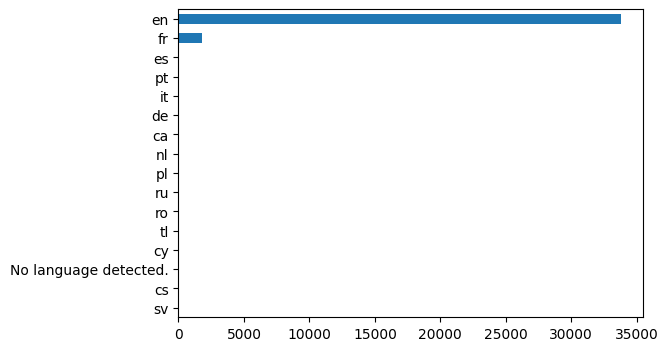

In [286]:
plt.figure(figsize=(6,4))
df3.lang.value_counts().sort_values().plot(kind = 'barh')

In [287]:
df3_eng = df3[df3.lang=='en']

In [288]:
df3_eng = df3_eng.reset_index(drop=True)

## Extract keywords

In order to extract keywords, I use the library summa, which implements the TextRank algorithm (similar to Google's PageRank) in order to extract important words from a text in an unsupervised way. It gives pretty good results, and it is very convenient since it's very easy to use.

In [108]:
def clean_text(text_data):
    tokens = tokenizer.tokenize(text_data)
    lowercased = [w.lower() for w in tokens]
    no_sw = [w for w in lowercased if (not w in stop_words_en and not w in stop_words_fr)]
    lemmas = [lemmatizer.lemmatize(word) for word in no_sw]
    no_punct = [w for w in lemmas if w.isalpha()]#if more time, avoid deleting dashes
    final = [w for w in no_punct if len(w)>2]
    return ' '.join(final)

In [290]:
df3_eng['clean_abstract']=df3_eng['abstract'].apply(clean_text)

In [291]:
df3_eng['clean_title']=df3_eng['title'].apply(clean_text)

In [292]:
df3_eng.head()

id  \
0  https://openalex.org/W2511949746   
1  https://openalex.org/W2805354595   
2  https://openalex.org/W2796277309   
3  https://openalex.org/W2969802526   
4  https://openalex.org/W2885896746   

                                               title  \
0  EAU-ESTRO-SIOG Guidelines on Prostate Cancer. ...   
1  Atezolizumab for First-Line Treatment of Metas...   
2  Review on nanoparticles and nanostructured mat...   
3  A global view of hepatocellular carcinoma: tre...   
4  Clinical Practice Guidelines for the Preventio...   

                             abstract_inverted_index  \
0  {'To': [0], 'present': [1, 392], 'a': [2, 49, ...   
1  {'The': [0, 84, 147, 183, 330], 'cancer-cell-k...   
2  {'Nanomaterials': [0], '(NMs)': [1], 'have': [...   
3  {'Hepatocellular': [0], 'carcinoma': [1], '(HC...   
4  {'To': [0], 'update': [1], 'and': [2, 15, 27, ...   

                                            abstract lang  \
0  To present a summary of the 2016 version of th...   en   
1  The cancer-cell-killing property of atezolizum...   en   
2  Nanomaterials (NMs) have gained prominence in ...   en   
3  Hepatocellular carcinoma (HCC) is the fourth m...   en   
4  To update and expand the 2013 Clinical Practic...   en   

                                      clean_abstract  \
0  present summary version european association u...   
1  property atezolizumab may enhanced blockade va...   
2  nanomaterials gained prominence technological ...   
3  hepatocellular carcinoma hcc fourth common cau...   
4  update expand clinical practice guideline mana...   

                                         clean_title  
0  guideline prostate part screening diagnosis lo...  
1  atezolizumab treatment metastatic nonsquamous ...  
2  review nanoparticles nanostructured material h...  
3  global view hepatocellular carcinoma trend ris...  
4  clinical practice guideline prevention managem...

In [293]:
def extract_keywords(row):
    kwds_abs = keywords.keywords(row['clean_abstract'], scores=False).split()[0:10]
    kwds_title = keywords.keywords(row['clean_title'], scores=False).split()[0:10]
    return list(set(kwds_abs+kwds_title))

In [294]:
df3_eng['keywords'] = df3_eng.apply(extract_keywords, axis=1)

In [295]:
df3_eng.to_csv('data/extracted_keywords.csv', index=False)

In [58]:
df3_eng = pd.read_csv('data/extracted_keywords.csv')  

In [297]:
df3_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33821 entries, 0 to 33820
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       33821 non-null  object
 1   title                    33821 non-null  object
 2   abstract_inverted_index  33821 non-null  object
 3   abstract                 33821 non-null  object
 4   lang                     33821 non-null  object
 5   clean_abstract           33821 non-null  object
 6   clean_title              33801 non-null  object
 7   keywords                 33821 non-null  object
dtypes: object(8)
memory usage: 2.1+ MB


### Parenthesis: Keyword extraction with YAKE

I also made a quick attempt to extract n-grams, since I realize that in a proper keyword extraction important n-grams should be extracted too. I did it with the library YAKE, but I didn't obtain satisfying results. I include an example here only for illustration. 

If I had had more time, I would have looked into other ways to extract n-grams, possibly by using the TextRank algorithm as well, but including common phrases as elements of the vocabulary..

In [302]:
import yake 

def extract_keywords_YAKE(text):
    language = "en"
    max_ngram_size = 3
    deduplication_thresold = 0.9
    deduplication_algo = 'seqm'
    windowSize = 1
    numOfKeywords = 5

    kw_extractor = yake.KeywordExtractor(lan=language, 
                                     n=max_ngram_size, 
                                     dedupLim=deduplication_thresold, 
                                     dedupFunc=deduplication_algo, 
                                     windowsSize=windowSize, 
                                     top=numOfKeywords)
                                            
    keywords = kw_extractor.extract_keywords(text)

    return keywords

In [304]:
example=df3_eng.clean_abstract[0]
example

'present summary version european association urology eau european society radiotherapy oncology estro international society geriatric oncology siog guideline screening diagnosis local treatment curative intent clinically localised prostate cancer pca working panel performed literature review new data guideline updated level evidence grade recommendation added based systematic review mutation added risk factor early aggressive addition gleason score international society urological pathology grading system systematic screening still instead individual strategy following detailed discussion taking account patient wish life expectancy must early antigen test use risk calculator one promising biomarker tool investigated might able limit overdetection insignificant breaking link diagnosis treatment may lower overtreatment multiparametric magnetic resonance imaging using standardised reporting replace systematic biopsy robustly nested within diagnostic key role local active surveillance alw

In [306]:
extract_keywords_YAKE(example)
#Even with just one example, it becomes obvious that the keywords are not very relevant.
#I would need to investigate more to see why it gives these results.
#For now, I leave this aside.

[('international society geriatric', 0.0002764127962115132),
 ('society radiotherapy oncology', 0.00031991192124899043),
 ('society geriatric oncology', 0.00031991192124899043),
 ('european society radiotherapy', 0.0003241202059164023),
 ('clinically localised prostate', 0.0003859936879586322)]

## Get most common keywords

Finally I extract the most common keywords.

In [155]:
flat_kwds = [item for items in [ast.literal_eval(item) for item in df3_eng.keywords.values] for item in items]
flat_kwds

['oncology',
 'treatment',
 'diagnosis',
 'local',
 'screening',
 'discussed',
 'increased',
 'guideline',
 'discussion',
 'prostate',
 'pca',
 'group',
 'patient',
 'survival',
 'bcp',
 'death',
 'abcp',
 'nonsquamous',
 'expression',
 'plus',
 'atezolizumab',
 'population',
 'technological',
 'nanomaterials',
 'prominence',
 'production',
 'growth',
 'property',
 'gained',
 'increased',
 'increase',
 'advancement',
 'nanoparticles',
 'preventable',
 'treatment',
 'medical',
 'view',
 'disease',
 'hcc',
 'prevention',
 'curative',
 'potentially',
 'liver',
 'potential',
 'outcome',
 'question',
 'patient',
 'recommendation',
 'pain',
 'developed',
 'survivor',
 'evidence',
 'disruption',
 'guideline',
 'clinical',
 'practice',
 'atrial',
 'patient',
 'noac',
 'noacs',
 'dosing',
 'antagonist',
 'oral',
 'anticoagulant',
 'anticoagulation',
 'use',
 'heart',
 'practical',
 'study',
 'prevalence',
 'global',
 'country',
 'diagnostic',
 'obstructive',
 'available',
 'data',
 'apnoea',
 '

By quickly inspecting the list keywords, I noticed there were a lot of very common words found in scientific literature. Since these words won't give us information about the content of particular papers (they act like stopwords in scientific literature), I remove them. I do this by useing a list of common academic words that can be found here: https://uclouvain.be/en/research-institutes/ilc/cecl/the-academic-keyword-list-akl.html

In [158]:
common_academic_ws = 'ability, absence, account, achievement, act, action, activity, addition, adoption, adult, advance, advantage, advice, age, aim, alternative, amount, analogy, analysis, application, approach, argument, aspect, assertion, assessment, assistance, association, assumption, attempt, attention, attitude, author, awareness, balance, basis, behaviour, being, belief, benefit, bias, birth, capacity, case, category, cause, centre, challenge, change, character, characteristic, choice, circumstance, class, classification, code, colleague, combination, commitment, committee, communication, community, comparison, complexity, compromise, concentration, concept, conception, concern, conclusion, condition, conduct, conflict, consensus, consequence, consideration, constraint, construction, content, contradiction, contrast, contribution, control, convention, correlation, country, creation, crisis, criterion, criticism, culture, damage, data, debate, decision, decline, defence, definition, degree, demand, description, destruction, determination, development, difference, difficulty, dilemma, dimension, disadvantage, discovery, discrimination, discussion, distinction, diversity, division, doctrine, effect, effectiveness, element, emphasis, environment, error, essence, establishment, evaluation, event, evidence, evolution, examination, example, exception, exclusion, existence, expansion, experience, experiment, explanation, exposure, extent, extreme, fact, factor, failure, feature, female, figure, finding, force, form, formation, function, future, gain, group, growth, guidance, guideline, hypothesis, idea, identity, impact, implication, importance, improvement, increase, indication, individual, influence, information, insight, instance, institution, integration, interaction, interest, interpretation, intervention, introduction, investigation, isolation, issue, kind, knowledge, lack, learning, level, likelihood, limit, limitation, link, list, literature, logic, loss, maintenance, majority, male, manipulation, mankind, material, means, measure, medium, member, method, minority, mode, model, motivation, movement, need, network, norm, notion, number, observation, observer, occurrence, operation, opportunity, option, organisation, outcome, output, parallel, parent, part, participant, past, pattern, percentage, perception, period, person, personality, perspective, phenomenon, point, policy, population, position, possibility, potential, practice, presence, pressure, problem, procedure, process, production, programme, progress, property, proportion, proposition, protection, provision, publication, purpose, quality, question, range, rate, reader, reality, reason, reasoning, recognition, reduction, reference, relation, relationship, relevance, report, representative, reproduction, requirement, research, resistance, resolution, resource, respect, restriction, result, review, rise, risk, role, rule, sample, scale, scheme, scope, search, section, selection, sense, separation, series, service, set, sex, shift, significance, similarity, situation, skill, society, solution, source, space, spread, standard, statistics, stimulus, strategy, stress, structure, subject, success, summary, support, survey, system, target, task, team, technique, tendency, tension, term, theme, theory, tolerance, topic, tradition, transition, trend, type, uncertainty, understanding, unit, use, validity, value, variation, variety, version, view, viewpoint, volume, whole, work, world, accept, account (for), achieve, acquire, act, adapt, adopt, advance, advocate, affect, aid, aim, allocate, allow, alter, analyse, appear, apply, argue, arise, assert, assess, assign, associate, assist, assume, attain, attempt, attend, attribute, avoid, base, be, become, benefit, can, cause, characterise, choose, cite, claim, clarify, classify, coincide, combine, compare, compete, comprise, concentrate, concern, conclude, conduct, confine, conform, connect, consider, consist, constitute, construct, contain, contrast, contribute, control, convert, correspond, create, damage, deal, decline, define, demonstrate, depend, derive, describe, design, destroy, determine, develop, differ, differentiate, diminish, direct, discuss, display, distinguish, divide, dominate, effect, eliminate, emerge, emphasize, employ, enable, encounter, encourage, enhance, ensure, establish, evaluate, evolve, examine, exceed, exclude, exemplify, exist, expand, experience, explain, expose, express, extend, facilitate, fail, favour, finance, focus, follow, form, formulate, function, gain, generate, govern, highlight, identify, illustrate, imply, impose, improve, include, incorporate, increase, indicate, induce, influence, initiate, integrate, interpret, introduce, investigate, involve, isolate, label, lack, lead, limit, link, locate, maintain, may, measure, neglect, note, obtain, occur, operate, outline, overcome, participate, perceive, perform, permit, pose, possess, precede, predict, present, preserve, prevent, produce, promote, propose, prove, provide, publish, pursue, quote, receive, record, reduce, refer, reflect, regard, regulate, reinforce, reject, relate, rely, remain, remove, render, replace, report, represent, reproduce, require, resolve, respond, restrict, result, retain, reveal, seek, select, separate, should, show, solve, specify, state, stimulate, strengthen, stress, study, submit, suffer, suggest, summarise, supply, support, sustain, tackle, tend, term, transform, treat, undermine, undertake, use, vary, view, write, yield, absolute, abstract, acceptable, accessible, active, actual, acute, additional, adequate, alternative, apparent, applicable, appropriate, arbitrary, available, average, basic, central, certain, clear, common, competitive, complete, complex, comprehensive, considerable, consistent, conventional, correct, critical, crucial, dependent, detailed, different, difficult, distinct, dominant, early, effective, equal, equivalent, essential, evident, excessive, experimental, explicit, extensive, extreme, far, favourable, final, fixed, following, formal, frequent, fundamental, future, general, great, high, human, ideal, identical, immediate, important, inadequate, incomplete, independent, indirect, individual, inferior, influential, inherent, initial, interesting, internal, large, late, leading, likely, limited, local, logical, main, major, male, maximum, mental, minimal, minor, misleading, modern, mutual, natural, necessary, negative, new, normal, obvious, original, other, overall, parallel, partial, particular, passive, past, permanent, physical, positive, possible, potential, practical, present, previous, primary, prime, principal, productive, profound, progressive, prominent, psychological, radical, random, rapid, rational, real, realistic, recent, related, relative, relevant, representative, responsible, restricted, scientific, secondary, selective, separate, severe, sexual, significant, similar, simple, single, so-called, social, special, specific, stable, standard, strict, subsequent, substantial, successful, successive, sufficient, suitable, surprising, symbolic, systematic, theoretical, total, traditional, true, typical, unique, unlike, unlikely, unsuccessful, useful, valid, valuable, varied, various, visual, vital, wide, widespread, above, accordingly, accurately, adequately, also, approximately, at best, basically, clearly, closely, commonly, consequently, considerably, conversely, correctly, directly, effectively, e.g., either, equally, especially, essentially, explicitly, extremely, fairly, far, for example, for instance, frequently, fully, further, generally, greatly, hence, highly, however, increasingly, indeed, independently, indirectly, inevitably, initially, in general, in particular, largely, less, mainly, more, moreover, most, namely, necessarily, normally, notably, often, only, originally, over, partially, particularly, potentially, previously, primarily, purely, readily, recently, relatively, secondly, significantly, similarly, simply, socially, solely somewhat, specifically, strongly, subsequently, successfully, thereby, therefore, thus, traditionally, typically, ultimately, virtually, wholly, widely, according to, although, an, as, as opposed to, as to, as well as, because, because of, between, both, by, contrary to, depending on, despite, due to, during, each, even though, fewer, first, former, from, for, given that, in, in addition to, in common with, in favour of, in relation to, in response to, in terms of, in that, in the light of, including, its, itself, latter, less, little, many, most, of, or, other than, per, prior to, provided, rather than, same, second, several, since, some, subject to, such, such as, than, that, the, their, themselves, these, third, this, those, to, unlike, upon, versus, whereas, whether, whether or not, which, within'

In [159]:
common_academic_ws = common_academic_ws.split(", ")

I add a few words I identified myself. If I had had more time, I would have refined this list further.

In [164]:
common_academic_ws.extend(['proposed', 'based', 'observed', 'associated', 'paper', 'studied', 'compared', 'provides'])

In [165]:
clean_kwds = [word for word in flat_kwds if word not in common_academic_ws]

In [166]:
def top_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(10)

In [167]:
print(top_frequent(clean_kwds))

[('magnetic', 1373), ('cell', 1092), ('temperature', 1066), ('structural', 1015), ('measurement', 960), ('phase', 954), ('energy', 892), ('performance', 848), ('surface', 796), ('dynamic', 769)]


Even with such a quick and unsupervised approach, this list makes quitea lot of sense. Perhaps some of these words should be added to the list of common academmic words to be removed, such as 'patient' or 'measurement'.

If I had more time, as I mentioned, I would work on including n-grams amongst the keywords and I would have done a proper experimentation with multiple algorithms for keyword extraction.

# Task 4: identify the most studied diseases

In [347]:
df4 = final[final["medicine"]==1].reset_index(drop=True)

In [348]:
df4 = df4[['id']]

In [349]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9556 entries, 0 to 9555
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      9556 non-null   object
dtypes: object(1)
memory usage: 74.8+ KB


For the purposes this exercise, I also limit myself to the abstracts that are in English.
In a proper study, I would have previously translated the abstracts or else work with models that can detect diseases in other languages (Spacy itself does provide such models).

In [350]:
other = df3_eng[['id', 'abstract']]
other.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33821 entries, 0 to 33820
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        33821 non-null  object
 1   abstract  33821 non-null  object
dtypes: object(2)
memory usage: 528.6+ KB


In [351]:
df4 = df4.join(other.set_index('id'), on='id', how='inner')
#the dataframe is smaller than all those that belonged to the concept Medicine, because there were some empty abstracts

In [352]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6995 entries, 0 to 9555
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6995 non-null   object
 1   abstract  6995 non-null   object
dtypes: object(2)
memory usage: 163.9+ KB


Next, I apply the NER model for diseases. Note that I don't clean the text at all before applying said model, since it seems to be sensitivie to things like capitalization. The examples I found didn't apply any cleaning at all, which probably means the model performs better without cleaning.

In a proper study, I would look into how the model works exactly and apply some preprocessing accordingly.

In [325]:
nlp = spacy.load("en_ner_bc5cdr_md")

In [328]:
def get_diseases(text):
    doc = nlp(text)
    pred = doc.ents
    diseases = [word.text for word in pred if word.label_=='DISEASE']
    return diseases

In [353]:
df4['diseases'] = df4['abstract'].apply(get_diseases)

In [354]:
df4.to_csv('data/extracted_diseases.csv', index=False)

In [2]:
df4 = pd.read_csv('data/extracted_diseases.csv')

In [4]:
df4.diseases

0       ['prostate cancer', 'aggressive disease', 'hyp...
1       ['nonsquamous non-small-cell lung cancer', 'NS...
2       ['Hepatocellular carcinoma', 'HCC', 'cancer-re...
3       ['Pain', 'Agitation', 'Delirium', 'Pain', 'Del...
4       ['atrial fibrillation', 'atrial fibrillation',...
                              ...                        
6990    ['Abstract Pseudomonas aeruginosa', 'opportuni...
6991                                                   []
6992                                  ['death', 'deaths']
6993                                                   []
6994                                                   []
Name: diseases, Length: 6995, dtype: object

In [5]:
dis = [wd for item in df4.diseases for wd in ast.literal_eval(item)]

In the list of extracted diseases, I identified some that do not seem to be diseases, so I remove them. This could be done much better and in a principled way, for instance, by checking the list of extracted against an existing list of diseases.

In [6]:
not_diseases=['pain', 'death', 'deaths', 'toxicity']

In [209]:
def normalize_diseases(text_data):
    
    tokens = tokenizer.tokenize(text_data)
    lowercased = [w.lower() for w in tokens]
    only_dis = [w for w in lowercased if w not in not_diseases]
    only_alpha=[w for w in only_dis if w.isalpha()]
    lemmas = [lemmatizer.lemmatize(w) for w in only_alpha]
    
    return ' '.join(lemmas)

In [210]:
clean_dis = [item for item in [normalize_diseases(item) for item in dis] if item!='']

In [211]:
print(top_frequent(clean_dis))

[('tumor', 981), ('cancer', 877), ('infection', 625), ('osa', 575), ('asthma', 461), ('copd', 314), ('trauma', 272), ('diabetes', 257), ('pd', 256), ('stroke', 253)]


In [212]:
def least_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common()[-10:-1]

In [213]:
print(least_frequent(clean_dis))

[('renal sequela', 1), ('cerebral or pulmonary oedema', 1), ('telomeropathy', 1), ('anal sphincter injury', 1), ('idiopathic infertility', 1), ('undernutrition', 1), ('airway inflammatory disease', 1), ('cit deficiency', 1), ('sluggishness', 1)]


# Task 5 (optional): clustering texts / topic modelling

In [59]:
df5 = df3_eng[['id','clean_abstract']].join(final.set_index('id'), on='id', how='inner')
df5 = df5.reset_index().drop(columns='index')

In [60]:
df5 = df5.drop(columns=['publication_year', 'publication_date'])

In [61]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33821 entries, 0 to 33820
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype    
---  ------                 --------------  -----    
 0   id                     33821 non-null  object   
 1   clean_abstract         33821 non-null  object   
 2   title                  33821 non-null  object   
 3   month_year             33821 non-null  period[M]
 4   publication_month      33821 non-null  int64    
 5   art                    33821 non-null  uint8    
 6   biology                33821 non-null  uint8    
 7   business               33821 non-null  uint8    
 8   chemistry              33821 non-null  uint8    
 9   computer-science       33821 non-null  uint8    
 10  economics              33821 non-null  uint8    
 11  engineering            33821 non-null  uint8    
 12  environmental-science  33821 non-null  uint8    
 13  geography              33821 non-null  uint8    
 14  geology               

In [62]:
vectorizer = TfidfVectorizer(max_df = 0.5, min_df = 2, 
                                 stop_words = 'english')
tfidf = vectorizer.fit_transform(df5["clean_abstract"])

In [63]:
vectorizer.get_feature_names_out()[:100]

array(['aaa', 'aac', 'aacr', 'aae', 'aags', 'aaipi', 'aaker', 'aao',
       'aaos', 'aap', 'aapc', 'aar', 'aasm', 'aast', 'aat', 'aatsr',
       'aav', 'aba', 'abacus', 'abancay', 'abandon', 'abandoned',
       'abandoning', 'abandonment', 'abaqus', 'abasic', 'abatacept',
       'abatement', 'abb', 'abbie', 'abbot', 'abbott', 'abbreviated',
       'abbreviation', 'abbvie', 'abc', 'abcp', 'abd', 'abdomen',
       'abdominal', 'abdominoperineal', 'abduction', 'abductive',
       'abdullah', 'abel', 'abelian', 'aberrant', 'aberrantly',
       'aberration', 'abf', 'abg', 'abidjan', 'abies', 'ability',
       'abiotic', 'abiotically', 'abl', 'ablated', 'ablates', 'ablating',
       'ablation', 'ablative', 'able', 'abmr', 'abnormal', 'abnormality',
       'abnormally', 'abo', 'aboard', 'abolish', 'abolished', 'abolishes',
       'abolishing', 'aborted', 'abortion', 'abortive', 'aboulker',
       'abound', 'aboveground', 'abovementioned', 'abp', 'abpm',
       'abrahamson', 'abramsky', 'abras

In [64]:
len(vectorizer.get_feature_names_out())

37461

In [65]:
# Tweak the two parameters below
number_topics = 4
batch_size = 128

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=number_topics, 
                                learning_decay = 0.7,  # 0.7, 0.9
                                random_state = 23,
                                max_iter = 20,
                                batch_size=batch_size) 

lda.fit(tfidf)

LatentDirichletAllocation(max_iter=20, n_components=4, random_state=23)

In [67]:
# Log Likelihood: como más alta, mejor
print("Log Likelihood: ", lda.score(tfidf))

# Perplexity: como más baja, mejor
print("Perplexity: ", lda.perplexity(tfidf))

Log Likelihood:  -2014350.3476769829
Perplexity:  13554.450608865056


In [68]:
for index, topic in enumerate(lda.components_):
    print('Top 30 words for Topic {}'.format(index))
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-30:]])
    print('\n')

Top 30 words for Topic 0
['period', 'event', 'velocity', 'model', 'depth', 'fault', 'site', 'atmospheric', 'forest', 'earthquake', 'region', 'area', 'river', 'precipitation', 'sea', 'ocean', 'plant', 'rock', 'mml', 'glacier', 'sediment', 'surface', 'seismic', 'water', 'change', 'climate', 'soil', 'snow', 'specie', 'ice']


Top 30 words for Topic 1
['thermal', 'quantum', 'measurement', 'sample', 'different', 'study', 'result', 'energy', 'structural', 'effect', 'diffraction', 'film', 'electron', 'layer', 'scattering', 'spin', 'crystal', 'high', 'neutron', 'using', 'field', 'state', 'surface', 'transition', 'property', 'material', 'phase', 'structure', 'temperature', 'magnetic']


Top 30 words for Topic 2
['effect', 'mutation', 'rate', 'median', 'level', 'response', 'analysis', 'result', 'factor', 'survival', 'tumor', 'age', 'therapy', 'activity', 'outcome', 'month', 'human', 'year', 'group', 'gene', 'risk', 'cancer', 'associated', 'disease', 'protein', 'clinical', 'treatment', 'study', '

In [69]:
doc_topic = lda.transform(tfidf)

In [71]:
docs_topics={}
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    docs_topics[n]=topic_most_pr

In [72]:
df_docs_topics = pd.DataFrame.from_dict(docs_topics, orient='index')

In [73]:
df_docs_topics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33821 entries, 0 to 33820
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       33821 non-null  int64
dtypes: int64(1)
memory usage: 528.5 KB


In [74]:
df_docs_topics=df_docs_topics.rename(columns={0:'topic'})

In [75]:
df_docs_topics

topic
0          2
1          2
2          1
3          2
4          2
...      ...
33816      3
33817      2
33818      1
33819      2
33820      3

[33821 rows x 1 columns]

In [76]:
dummies = pd.get_dummies(df_docs_topics.astype(str))

In [78]:
final_df5 = df5.join(dummies, how='inner')

In [85]:
trimmed_df=final_df5.drop(columns=['id','clean_abstract','title','month_year','publication_month'])
jac_sim = 1 - pairwise_distances(trimmed_df.T, metric = "hamming")
jac_sim = pd.DataFrame(jac_sim, index=trimmed_df.columns, columns=trimmed_df.columns)

#brief discussion on how to calculate correlation of binary variables: https://stackoverflow.com/questions/37003272/how-to-compute-jaccard-similarity-from-a-pandas-dataframe

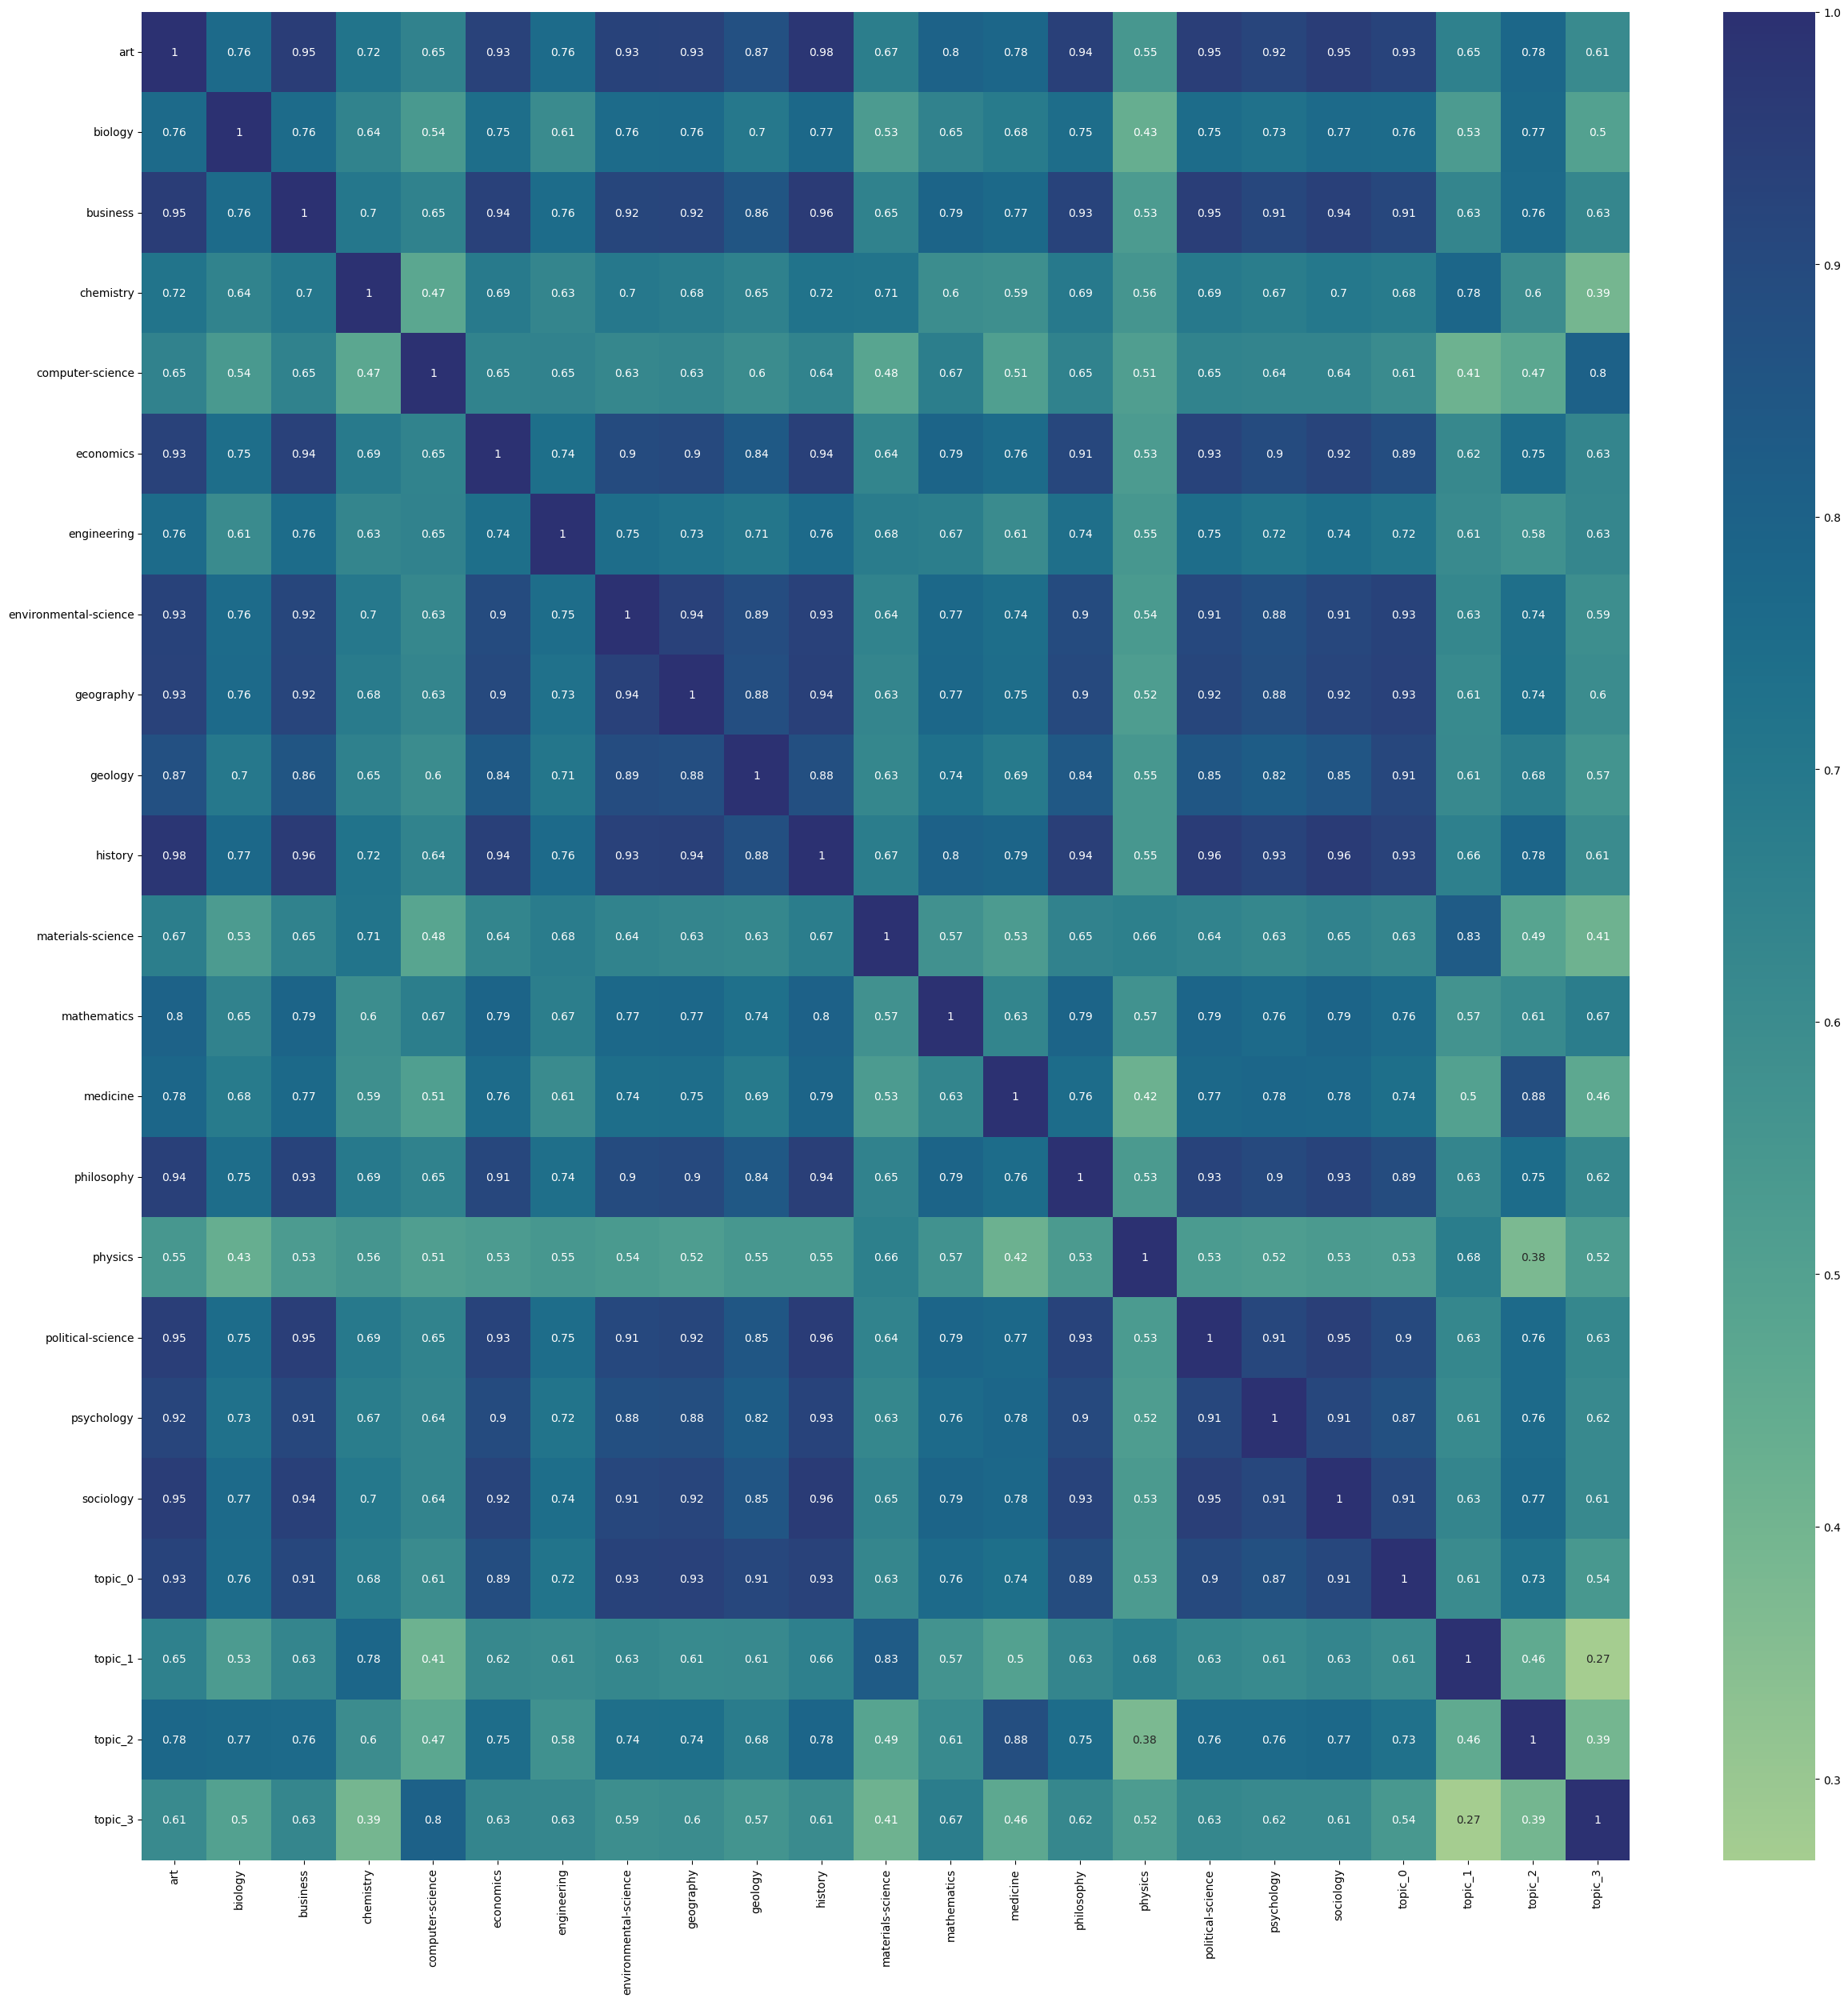

In [86]:
plt.rcParams["figure.figsize"] = (30,30)
sns.heatmap(jac_sim, cmap="crest", annot=True)
plt.show()

In [87]:
for n in range(4):
    topic = 'topic_{}'.format(n)
    top = list(jac_sim.nlargest(6, topic).index)
    print(topic, top)

topic_0 ['topic_0', 'geography', 'history', 'environmental-science', 'art', 'geology']
topic_1 ['topic_1', 'materials-science', 'chemistry', 'physics', 'history', 'art']
topic_2 ['topic_2', 'medicine', 'history', 'art', 'sociology', 'biology']
topic_3 ['topic_3', 'computer-science', 'mathematics', 'economics', 'business', 'engineering']


In [ ]:
#topic 0: Geology-environ-geography
#topic 1: Chemistry-materials-physics
#topic 2: Medicine-biology
#topic 3: Maths-engineering-econ

#History and Art. And in general humanities did not get well classified in the model. Probably because there are less entities.

#with 4 topics was not bad.

#if more time, use other types of vectorization, a proper hyperparameter tuning of LDA

In [88]:
df_docs_topics.value_counts()

topic
3        13411
1        11347
2         7054
0         2009
dtype: int64

# Task 6 (optional): remove duplicate entries

In [98]:
df6 = df3
df6 = df6.dropna().reset_index(drop=True)

In [99]:
def slice_text(text):
    fragments = [text[i:i+4000] for i in range(0, len(text), 4000)]
    return fragments

In [100]:
def translate_to_eng(row):
    if row.lang!='en':
        print("processing row {row_name} of abstract with length {abstract_length} ...".format(
            row_name = row.name,
            abstract_length=len(row['abstract'])
        ))
        try:
            if len(row.abstract) < 5000:
                translated = GoogleTranslator(source='auto', target='en').translate(row['abstract'])  # output -> Weiter so, du bist großartig
                return translated
            else:
                full_trans=[]
                chunks = slice_text(row.abstract)
                for chunk in chunks:
                    translated = GoogleTranslator(source='auto', target='en').translate(chunk)
                    full_trans.append(translated)
                return ' '.join(full_trans)
        except Exception as exception:
            print(exception)
            return 'Translation not available'
    else:
        return row['abstract']
    

In [102]:
df6['eng_translation']=df6.apply(translate_to_eng, axis=1)

processing row 1103 of abstract with length 3919 ...
processing row 2087 of abstract with length 3546 ...
processing row 2339 of abstract with length 3528 ...
processing row 2560 of abstract with length 3663 ...
processing row 2953 of abstract with length 3675 ...
processing row 3649 of abstract with length 861 ...
processing row 4451 of abstract with length 4076 ...
processing row 5185 of abstract with length 3245 ...
processing row 6259 of abstract with length 677 ...
processing row 6671 of abstract with length 1816 ...
processing row 6918 of abstract with length 2 ...
processing row 7435 of abstract with length 2 ...
processing row 8268 of abstract with length 5144 ...
processing row 8387 of abstract with length 8 ...
processing row 8403 of abstract with length 1620 ...
processing row 8587 of abstract with length 157 ...
processing row 10326 of abstract with length 4438 ...
processing row 10906 of abstract with length 1810 ...
processing row 11699 of abstract with length 798 ...
pro

processing row 23083 of abstract with length 864 ...
processing row 23147 of abstract with length 2970 ...
processing row 23204 of abstract with length 527 ...
processing row 23240 of abstract with length 1109 ...
processing row 23249 of abstract with length 1967 ...
processing row 23256 of abstract with length 200 ...
processing row 23266 of abstract with length 568 ...
processing row 23311 of abstract with length 3186 ...
processing row 23343 of abstract with length 388 ...
processing row 23345 of abstract with length 2667 ...
processing row 23406 of abstract with length 2107 ...
processing row 23413 of abstract with length 783 ...
processing row 23418 of abstract with length 1712 ...
processing row 23426 of abstract with length 1098 ...
processing row 23446 of abstract with length 1518 ...
processing row 23489 of abstract with length 1004 ...
processing row 23504 of abstract with length 2083 ...
processing row 23505 of abstract with length 2535 ...
processing row 23529 of abstract w

processing row 26827 of abstract with length 2740 ...
processing row 26838 of abstract with length 2617 ...
processing row 26867 of abstract with length 1640 ...
processing row 26874 of abstract with length 2129 ...
processing row 26892 of abstract with length 2391 ...
processing row 26896 of abstract with length 1737 ...
processing row 26911 of abstract with length 490 ...
processing row 26979 of abstract with length 1337 ...
processing row 27045 of abstract with length 328 ...
processing row 27057 of abstract with length 892 ...
processing row 27085 of abstract with length 1051 ...
processing row 27091 of abstract with length 1052 ...
processing row 27149 of abstract with length 1359 ...
processing row 27198 of abstract with length 1534 ...
processing row 27200 of abstract with length 480 ...
processing row 27202 of abstract with length 544 ...
processing row 27203 of abstract with length 370 ...
processing row 27293 of abstract with length 1504 ...
processing row 27311 of abstract w

processing row 28530 of abstract with length 772 ...
processing row 28540 of abstract with length 764 ...
processing row 28541 of abstract with length 970 ...
processing row 28544 of abstract with length 562 ...
processing row 28545 of abstract with length 1740 ...
processing row 28548 of abstract with length 1661 ...
processing row 28549 of abstract with length 510 ...
processing row 28550 of abstract with length 465 ...
processing row 28551 of abstract with length 1382 ...
processing row 28552 of abstract with length 385 ...
processing row 28557 of abstract with length 429 ...
processing row 28558 of abstract with length 1125 ...
processing row 28561 of abstract with length 863 ...
processing row 28564 of abstract with length 971 ...
processing row 28567 of abstract with length 725 ...
processing row 28568 of abstract with length 382 ...
processing row 28570 of abstract with length 596 ...
processing row 28580 of abstract with length 1094 ...
processing row 28581 of abstract with len

processing row 29102 of abstract with length 1518 ...
processing row 29103 of abstract with length 1605 ...
processing row 29104 of abstract with length 1151 ...
processing row 29105 of abstract with length 1064 ...
processing row 29136 of abstract with length 800 ...
processing row 29149 of abstract with length 1187 ...
processing row 29157 of abstract with length 303 ...
processing row 29161 of abstract with length 1878 ...
processing row 29164 of abstract with length 2807 ...
processing row 29166 of abstract with length 987 ...
processing row 29167 of abstract with length 3056 ...
processing row 29168 of abstract with length 1708 ...
processing row 29169 of abstract with length 1300 ...
processing row 29170 of abstract with length 2143 ...
processing row 29171 of abstract with length 1208 ...
processing row 29172 of abstract with length 1468 ...
processing row 29173 of abstract with length 2060 ...
processing row 29175 of abstract with length 2297 ...
processing row 29177 of abstrac

processing row 29605 of abstract with length 1896 ...
processing row 29606 of abstract with length 1456 ...
processing row 29607 of abstract with length 1688 ...
processing row 29608 of abstract with length 2389 ...
processing row 29610 of abstract with length 1801 ...
processing row 29611 of abstract with length 2233 ...
processing row 29612 of abstract with length 728 ...
processing row 29613 of abstract with length 1576 ...
processing row 29614 of abstract with length 1569 ...
processing row 29615 of abstract with length 1708 ...
processing row 29619 of abstract with length 502 ...
processing row 29632 of abstract with length 945 ...
processing row 29634 of abstract with length 1454 ...
processing row 29659 of abstract with length 2207 ...
processing row 29660 of abstract with length 828 ...
processing row 29664 of abstract with length 987 ...
processing row 29667 of abstract with length 1191 ...
processing row 29675 of abstract with length 447 ...
processing row 29681 of abstract w

processing row 30076 of abstract with length 2218 ...
processing row 30077 of abstract with length 2845 ...
processing row 30079 of abstract with length 2911 ...
processing row 30080 of abstract with length 4653 ...
processing row 30081 of abstract with length 2636 ...
processing row 30082 of abstract with length 2465 ...
processing row 30083 of abstract with length 1915 ...
processing row 30084 of abstract with length 2338 ...
processing row 30085 of abstract with length 1857 ...
processing row 30086 of abstract with length 3176 ...
processing row 30087 of abstract with length 2246 ...
processing row 30088 of abstract with length 2117 ...
processing row 30089 of abstract with length 2526 ...
processing row 30095 of abstract with length 974 ...
processing row 30097 of abstract with length 1026 ...
processing row 30118 of abstract with length 3080 ...
processing row 30120 of abstract with length 2225 ...
processing row 30122 of abstract with length 1087 ...
processing row 30126 of abstr

processing row 30751 of abstract with length 2805 ...
processing row 30756 of abstract with length 2245 ...
processing row 30757 of abstract with length 646 ...
processing row 30762 of abstract with length 700 ...
processing row 30764 of abstract with length 500 ...
processing row 30765 of abstract with length 1100 ...
processing row 30766 of abstract with length 692 ...
processing row 30768 of abstract with length 532 ...
processing row 30772 of abstract with length 1007 ...
processing row 30781 of abstract with length 1243 ...
processing row 30782 of abstract with length 1858 ...
processing row 30805 of abstract with length 13 ...
processing row 30806 of abstract with length 1702 ...
processing row 30809 of abstract with length 1179 ...
processing row 30811 of abstract with length 1214 ...
processing row 30813 of abstract with length 944 ...
processing row 30820 of abstract with length 767 ...
processing row 30830 of abstract with length 2155 ...
processing row 30836 of abstract with

processing row 31308 of abstract with length 3134 ...
processing row 31309 of abstract with length 2791 ...
processing row 31310 of abstract with length 3137 ...
processing row 31311 of abstract with length 682 ...
processing row 31312 of abstract with length 4744 ...
processing row 31313 of abstract with length 955 ...
processing row 31316 of abstract with length 1957 ...
processing row 31317 of abstract with length 2865 ...
processing row 31318 of abstract with length 2083 ...
processing row 31327 of abstract with length 1813 ...
processing row 31329 of abstract with length 492 ...
processing row 31330 of abstract with length 355 ...
processing row 31361 of abstract with length 450 ...
processing row 31364 of abstract with length 774 ...
processing row 31366 of abstract with length 599 ...
processing row 31370 of abstract with length 1627 ...
processing row 31376 of abstract with length 324 ...
processing row 31383 of abstract with length 647 ...
processing row 31395 of abstract with

processing row 32091 of abstract with length 776 ...
processing row 32093 of abstract with length 1635 ...
processing row 32100 of abstract with length 1027 ...
processing row 32102 of abstract with length 895 ...
processing row 32103 of abstract with length 679 ...
processing row 32104 of abstract with length 891 ...
processing row 32105 of abstract with length 836 ...
processing row 32127 of abstract with length 984 ...
processing row 32129 of abstract with length 2021 ...
processing row 32130 of abstract with length 1770 ...
processing row 32131 of abstract with length 2416 ...
processing row 32132 of abstract with length 2591 ...
processing row 32133 of abstract with length 2586 ...
processing row 32134 of abstract with length 2581 ...
processing row 32135 of abstract with length 2057 ...
processing row 32136 of abstract with length 1748 ...
processing row 32137 of abstract with length 1163 ...
processing row 32139 of abstract with length 1754 ...
processing row 32140 of abstract w

processing row 32779 of abstract with length 930 ...
processing row 32790 of abstract with length 1718 ...
processing row 32800 of abstract with length 889 ...
processing row 32802 of abstract with length 676 ...
processing row 32803 of abstract with length 528 ...
processing row 32854 of abstract with length 3548 ...
processing row 32879 of abstract with length 1334 ...
processing row 32901 of abstract with length 731 ...
processing row 32912 of abstract with length 1520 ...
processing row 32959 of abstract with length 825 ...
processing row 32968 of abstract with length 154 ...
processing row 32991 of abstract with length 1874 ...
processing row 32994 of abstract with length 1315 ...
processing row 32995 of abstract with length 1485 ...
processing row 32996 of abstract with length 613 ...
processing row 32999 of abstract with length 732 ...
processing row 33000 of abstract with length 1335 ...
processing row 33002 of abstract with length 1481 ...
processing row 33004 of abstract with

processing row 33513 of abstract with length 2782 ...
processing row 33514 of abstract with length 2249 ...
processing row 33515 of abstract with length 2896 ...
processing row 33516 of abstract with length 3891 ...
processing row 33517 of abstract with length 3425 ...
processing row 33518 of abstract with length 1643 ...
processing row 33519 of abstract with length 2112 ...
processing row 33520 of abstract with length 2841 ...
processing row 33521 of abstract with length 2427 ...
processing row 33522 of abstract with length 3588 ...
processing row 33523 of abstract with length 2801 ...
processing row 33524 of abstract with length 3600 ...
processing row 33525 of abstract with length 2809 ...
processing row 33526 of abstract with length 3630 ...
processing row 33527 of abstract with length 3280 ...
processing row 33528 of abstract with length 1314 ...
processing row 33530 of abstract with length 3157 ...
processing row 33531 of abstract with length 2421 ...
processing row 33532 of abst

processing row 34474 of abstract with length 1524 ...
processing row 34479 of abstract with length 1022 ...
processing row 34484 of abstract with length 3477 ...
processing row 34487 of abstract with length 4514 ...
processing row 34489 of abstract with length 3326 ...
processing row 34492 of abstract with length 2307 ...
processing row 34503 of abstract with length 4609 ...
processing row 34504 of abstract with length 2686 ...
processing row 34509 of abstract with length 1732 ...
processing row 34510 of abstract with length 2648 ...
processing row 34516 of abstract with length 736 ...
processing row 34517 of abstract with length 416 ...
processing row 34541 of abstract with length 515 ...
processing row 34542 of abstract with length 777 ...
processing row 34556 of abstract with length 1269 ...
processing row 34578 of abstract with length 1071 ...
processing row 34580 of abstract with length 974 ...
processing row 34581 of abstract with length 122 ...
processing row 34595 of abstract w

In [110]:
df6[df6.eng_translation.isna()]
#there is a null, because I did not realize that there was an abstract containing a single dot.

id  \
29722  https://openalex.org/W2890805169   

                                                   title  \
29722  François Robinet – Silences et récits. Les méd...   

      abstract_inverted_index abstract                   lang eng_translation  
29722              {'.': [0]}        .  No language detected.             NaN

In [111]:
df6=df6[~df6.eng_translation.isna()].reset_index(drop=True)

In [112]:
df6['clean_eng_text']=df6.eng_translation.apply(clean_text)

In [113]:
df6.to_csv('data/translated_clean.csv', index=False)

In [114]:
df6 = pd.read_csv('data/translated_clean.csv')

In [115]:
df6

id  \
0      https://openalex.org/W2511949746   
1      https://openalex.org/W2805354595   
2      https://openalex.org/W2796277309   
3      https://openalex.org/W2969802526   
4      https://openalex.org/W2885896746   
...                                 ...   
35794  https://openalex.org/W4200599600   
35795  https://openalex.org/W4205416072   
35796  https://openalex.org/W4205834098   
35797  https://openalex.org/W4207070375   
35798  https://openalex.org/W4225842698   

                                                   title  \
0      EAU-ESTRO-SIOG Guidelines on Prostate Cancer. ...   
1      Atezolizumab for First-Line Treatment of Metas...   
2      Review on nanoparticles and nanostructured mat...   
3      A global view of hepatocellular carcinoma: tre...   
4      Clinical Practice Guidelines for the Preventio...   
...                                                  ...   
35794  Superquantiles at Work: Machine Learning Appli...   
35795  Combined Use of Whole Exome Sequencing and CRI...   
35796  Nanoscale mineralogy and organic structure in ...   
35797  HIV-1 Nef Protein Affects Cytokine and Extrace...   
35798  Superquantiles at Work: Machine Learning Appli...   

                                 abstract_inverted_index  \
0      {'To': [0], 'present': [1, 392], 'a': [2, 49, ...   
1      {'The': [0, 84, 147, 183, 330], 'cancer-cell-k...   
2      {'Nanomaterials': [0], '(NMs)': [1], 'have': [...   
3      {'Hepatocellular': [0], 'carcinoma': [1], '(HC...   
4      {'To': [0], 'update': [1], 'and': [2, 15, 27, ...   
...                                                  ...   
35794  {'R.': [0], 'Tyrell': [1], 'Rockafellar': [2],...   
35795  {'The': [0], 'genetic': [1], 'landscape': [2],...   
35796  {'Meteorite': [0], 'matrices': [1, 187], 'from...   
35797  {'Plasmacytoid': [0], 'dendritic': [1, 7, 73],...   
35798  {'R.': [0], 'Tyrell': [1], 'Rockafellar': [2],...   

                                                abstract lang  \
0      To present a summary of the 2016 version of th...   en   
1      The cancer-cell-killing property of atezolizum...   en   
2      Nanomaterials (NMs) have gained prominence in ...   en   
3      Hepatocellular carcinoma (HCC) is the fourth m...   en   
4      To update and expand the 2013 Clinical Practic...   en   
...                                                  ...  ...   
35794  R. Tyrell Rockafellar and his collaborators in...   en   
35795  The genetic landscape of male infertility is h...   en   
35796  Meteorite matrices from primitive chondrites a...   en   
35797  Plasmacytoid dendritic cells (pDCs) are a uniq...   en   
35798  R. Tyrell Rockafellar and collaborators introd...   en   

                                         eng_translation  \
0      To present a summary of the 2016 version of th...   
1      The cancer-cell-killing property of atezolizum...   
2      Nanomaterials (NMs) have gained prominence in ...   
3      Hepatocellular carcinoma (HCC) is the fourth m...   
4      To update and expand the 2013 Clinical Practic...   
...                                                  ...   
35794  R. Tyrell Rockafellar and his collaborators in...   
35795  The genetic landscape of male infertility is h...   
35796  Meteorite matrices from primitive chondrites a...   
35797  Plasmacytoid dendritic cells (pDCs) are a uniq...   
35798  R. Tyrell Rockafellar and collaborators introd...   

                                          clean_eng_text  
0      present summary version european association u...  
1      property atezolizumab may enhanced blockade va...  
2      nanomaterials gained prominence technological ...  
3      hepatocellular carcinoma hcc fourth common cau...  
4      update expand clinical practice guideline mana...  
...                                                  ...  
35794  tyrell rockafellar collaborator introduced ser...  
35795  genetic landscape male infertility highly esti...  
35796  meteorite matrix primitive chondrite i

In [117]:
df6[df6.clean_eng_text.isna()]

id  \
6918   https://openalex.org/W3085752845   
7435   https://openalex.org/W2976798654   
13118  https://openalex.org/W3155061748   
15255  https://openalex.org/W3210135915   
18500  https://openalex.org/W3086525143   
19566  https://openalex.org/W3209985844   
22735  https://openalex.org/W3196117178   
34943  https://openalex.org/W3198029832   

                                                   title  \
6918   How citizen scientists contribute to monitor p...   
7435   How neighbourhood interactions control the tem...   
13118  Organic management and landscape heterogeneity...   
15255  Factors influencing the rate of formation of t...   
18500  Measuring the fabric evolution of sand – appli...   
19566  Disentangling responses to natural stressor an...   
22735  Dislocating Urban Theory: Learning with Food‐V...   
34943  Does spatial sorting occur in the invasive Asi...   

      abstract_inverted_index abstract lang eng_translation clean_eng_text  
6918              {'en': [0]}       en   nl              in            NaN  
7435              {'en': [0]}       en   nl              in            NaN  
13118             {'en': [0]}       en   nl              in            NaN  
15255             {'en': [0]}       en   nl              in            NaN  
18500             {'en': [0]}       en   nl              in            NaN  
19566             {'en': [0]}       en   nl              in            NaN  
22735             {'en': [0]}       en   nl              in            NaN  
34943             {'en': [0]}       en   nl              in            NaN

In [118]:
df6=df6[~df6.clean_eng_text.isna()].reset_index(drop=True)

In [119]:
start = time()#calculamos cuánto se tarda en crear los vectores

vectorizer = TfidfVectorizer(max_df = 0.5, min_df = 2)
tfidf = vectorizer.fit_transform(df6.clean_eng_text)

end = time()
print("It took {} sec to fit and transform all documents.".format(end - start))

It took 4.927570104598999 sec to fit and transform all documents.


In [120]:
tfidf_dict = vectorizer.vocabulary_
df_tf_idf_voc = pd.DataFrame({'column_name': list(tfidf_dict.keys()), 'column_index': list(tfidf_dict.values())})
df_tf_idf_voc = df_tf_idf_voc.sort_values(by='column_index')

In [121]:
df_tfidf = pd.DataFrame(tfidf.toarray())
df_tfidf.columns = df_tf_idf_voc['column_name'].tolist()

In [122]:
df_tfidf.head()
#if more time, I would have done a more careful cleaning, including deleting words with 3 letter repetitions

aaa  aac  aacr  aae  aags  aai  aaipi  aaker  aao  aaos  ...  μmol  μpa  \
0  0.0  0.0   0.0  0.0   0.0  0.0    0.0    0.0  0.0   0.0  ...   0.0  0.0   
1  0.0  0.0   0.0  0.0   0.0  0.0    0.0    0.0  0.0   0.0  ...   0.0  0.0   
2  0.0  0.0   0.0  0.0   0.0  0.0    0.0    0.0  0.0   0.0  ...   0.0  0.0   
3  0.0  0.0   0.0  0.0   0.0  0.0    0.0    0.0  0.0   0.0  ...   0.0  0.0   
4  0.0  0.0   0.0  0.0   0.0  0.0    0.0    0.0  0.0   0.0  ...   0.0  0.0   

   μxanes  μxrd  μxrf  πfet  ρhv  ψdp  ﬁelds  ﬁrst  
0     0.0   0.0   0.0   0.0  0.0  0.0    0.0   0.0  
1     0.0   0.0   0.0   0.0  0.0  0.0    0.0   0.0  
2     0.0   0.0   0.0   0.0  0.0  0.0    0.0   0.0  
3     0.0   0.0   0.0   0.0  0.0  0.0    0.0   0.0  
4     0.0   0.0   0.0   0.0  0.0  0.0    0.0   0.0  

[5 rows x 40114 columns]

In [144]:
def get_highest_sims(k, sim_thresh):
    df_tfidf.iloc[k].values
    reference_review_matrix = np.expand_dims(np.array(df_tfidf.iloc[k].values), axis=0)
    distances_to_reference_review = cosine_similarity(reference_review_matrix, tfidf)
    df_sim=pd.DataFrame(df6['clean_eng_text'])
    df_sim["Distance"]=distances_to_reference_review.transpose()
    res={}
    if not df_sim[(df_sim['Distance']>sim_thresh) & (df_sim.index!=k)].empty:
        res['Index']=str(k)
        res['Original_abstract']=df6['clean_eng_text'].iloc[k]
        res['Similar abstracts']=df_sim[(df_sim['Distance']>sim_thresh) & (df_sim.index!=k)].values.tolist()
        return res

In [151]:
k = 0
all_res = []
while k in range(tfidf.shape[0]):
    res = get_highest_sims(k, 0.8)
    if res != None:
        all_res.append(res)
    k=k+1

In [152]:
with open('data/similar_abstracts', 'w') as f:
    json.dump(all_res, f, indent=2)

In [153]:
all_res

[{'Index': '5',
  'Original_abstract': 'current manuscript second update original practical guide published heidbuchel european heart rhythm association practical guide use new oral anticoagulant patient atrial europace heidbuchel updated european heart rhythm association practical guide use antagonist anticoagulant patient atrial europace antagonist oral anticoagulant noacs alternative vitamin antagonist vkas prevent stroke patient atrial fibrillation emerged preferred choice particularly patient newly started physician patient becoming accustomed use drug clinical however many unresolved question optimally use agent specific clinical situation european heart rhythm association ehra set coordinate unified way informing physician use different writing group identified topic concrete clinical scenario practical answer formulated based available topic follows eligibility noacs practical scheme patient noacs ensuring adherence prescribed oral anticoagulant intake switching anticoagulant r

In [ ]:
#what I would do is extract further similarity measures from other features. For instance, form the title, DOI, authors, etc. And either train a ML model to predict duplicity or simply, aggregate all the measures and set a threshold from which we consider that there is duplicity.


# Task 7: Open question

# Task 7

Observations:
- The connectivity is not well distributed.
-

- Why should we worry about connectivity?
    - Is it good to be conected?
        - Check impact of work of connected actors
    - Does connectivity have a relationship with impact outside of academia? I would expect so, since often this kind of impact happens on a local level.


- I would try to analyse other forms of connectivity:
    - Can we detect publications arising from specific conferences/events? We should then promote events of a similar type.
    - Can we detect specific journals-publishers giving rise to more connected publications? We should see what these journals-publishers are doing to promote connectivity.
    - Which topics foster more connectivity? Which topics are the more connected actors working on? We should probably promote other topics so the same occurs on those other areas.
    
- What makes the more connected actors be more connected?
    - I would do an exhaustive analysis of which factors are correlated with connectedness. Preliminary ideas:
        - Impact of their work: authors that are more cited attract more collaboration (or is the collaboration the cause of the former?)
        - Location: is it actually their institutions which drive connection?
      
    
2 types of actions:

1) Award connectedness: PEOPLE: award connectedness -- in applications, assign a connectedness degree to each applicant and take into account in awarding funding as one more factor in the final punctuation. But be careful to not overfund people who are very connected. Give less weight to outliers.

    Depending on what is driving connectivity, give more emphasis to one or other:
    EVENTS: award connectedness (with at least 2 Grenoble speakers)
    BOOKS: award connectedness (with at least 2 Grenoble authors)
    PROJECTS: award connectedness (with at least 2 Grenoble institutions)
    
2) Other actions to promote connectedness: avoid concentration of resources to achieve a more distributed network. Special funding programmes for under connected areas of research and for isolated institutions to carry out collaboration projects.

In [ ]:
open_access: to see if it is correlated with higeher collaboration
n_grams: to access text of work